# Classification II – Sentiment Analysis

For companies, it is vital to closely monitor the public reception of key events, such as product launches or press releases. With real-time access and easy accessibility of user-generated content on Twitter, it is now possible to do sentiment classification of tweets. As this shows that there obviously exists a market, this notebook's goal is to use the classification muscles built in the last chapter to build the home-grown sentiment classifier.

## Sketching the roadmap

Sentiment analysis of tweets is particularly hard, because of Twitter's size limitation per message. This leads to a special syntax, creative abbreviations, and seldom-well-formed
sentences. The typical approach of analyzing sentences, aggregating their sentiment information per paragraph, and then calculating the overall sentiment of a document does not work here.

Clearly, the goal is not try to build a state-of-the-art sentiment classifier. Instead, the goal is to do the following:
* Use this scenario as a vehicle to introduce yet another classification algorithm, Naïve Bayes
* Explain how Part Of Speech (POS) tagging works and how it can help
* Show some more tricks from the scikit-learn toolbox that can come in handy

## Fetching the Twitter data

Naturally, tweets and their corresponding labels that describe sentiments are needed. In this notebook, the corpus from Niek Sanders will be used, who has done an awesome job of manually
labeling more than 5,000 tweets as positive, negative, or neutral and permission to use it in this notebook has been granted.

To comply with Twitter terms of services, any data from Twitter will not be provided nor any real tweets will not be shown in this notebook. Instead, Sander's hand-labeled data can be used, which contains the tweet IDs and their hand-labeled sentiments. In order to play nicely with Twitter's servers, it will take quite some time to download all the data for more than
5,000 tweets, which means it is a good idea to start it right away. 

The data comes with four sentiment labels, which are returned by load_sanders_data():

In [1]:
import time
import os
import csv
import json
import twitter
import numpy as np

DATA_DIR = "data"
if not os.path.exists(DATA_DIR):
    os.mkdir(DATA_DIR)

def get_user_params(DATA_DIR):
    user_params = {}

    # get user input params
    user_params['inList'] = os.path.join(DATA_DIR, 'corpus.csv')
    user_params['outList'] = os.path.join(DATA_DIR, 'full-corpus.csv')
    user_params['rawDir'] = os.path.join(DATA_DIR, 'rawdata/')

    return user_params

# for some reasons TWeets disappear. In this file we collect those
MISSING_ID_FILE = os.path.join(DATA_DIR, "missing.tsv")
NOT_AUTHORIZED_ID_FILE = os.path.join(DATA_DIR, "not_authorized.tsv")

def read_total_list(in_filename):
    # read total fetch list csv
    with open(in_filename, 'rt') as f:
        reader = csv.reader(f, delimiter=',', quotechar='"')

        if os.path.exists(MISSING_ID_FILE):
            missing_ids = [line.strip() for line in open(MISSING_ID_FILE, "r").readlines()]
        else:
            missing_ids = []

        if os.path.exists(NOT_AUTHORIZED_ID_FILE):
            not_authed_ids = [line.strip() for line in open(NOT_AUTHORIZED_ID_FILE, "r").readlines()]
        else:
            not_authed_ids = []

        print("We will skip {} tweets that are not available or visible any more on twitter".format(len(missing_ids) + len(not_authed_ids)))

        ignore_ids = set(missing_ids + not_authed_ids)
        total_list = []

        for row in reader:
            if row[2] not in ignore_ids:
                total_list.append(row)

        return total_list

def parse_tweet_json(filename):

    # read tweet
    fp = open(filename, 'r')

    # parse json
    try:
        tweet_json = json.load(fp)
    except ValueError as e:
        print(e)
        raise RuntimeError('error parsing json')

    # look for twitter api error msgs
    if 'error' in tweet_json or 'errors' in tweet_json:
        raise RuntimeError('error in downloaded tweet')

    # extract creation date and tweet text
    return [tweet_json['created_at'], tweet_json['text']]

def purge_already_fetched(fetch_list, raw_dir):

    # list of tweet ids that still need downloading
    rem_list = []
    count_done = 0

    # check each tweet to see if we have it
    for item in fetch_list:

        # check if json file exists
        tweet_file = os.path.join(raw_dir, item[2] + '.json')
        if os.path.exists(tweet_file):

            # attempt to parse json file
            try:
                parse_tweet_json(tweet_file)
                count_done += 1
            except RuntimeError:
                print("Error parsing", item)
                rem_list.append(item)
        else:
            rem_list.append(item)

    print("We have already downloaded {} tweets.".format(count_done))

    return rem_list

CONSUMER_KEY = ''
CONSUMER_SECRET = ''

ACCESS_TOKEN_KEY = ''
ACCESS_TOKEN_SECRET = ''
api = twitter.Twitter(auth=twitter.OAuth(consumer_key=CONSUMER_KEY, consumer_secret=CONSUMER_SECRET, token=ACCESS_TOKEN_KEY, token_secret=ACCESS_TOKEN_SECRET))

def download_tweets(fetch_list, raw_dir):

    # ensure raw data directory exists
    if not os.path.exists(raw_dir):
        os.mkdir(raw_dir)

    # download tweets
    for idx in range(0, len(fetch_list)):
        # current item
        item = fetch_list[idx]
        print(item)

        print('--> downloading tweet #{} ({} of {})'.format(item[2], idx + 1, len(fetch_list)))

        try:
            response = api.statuses.show(_id=item[2])

            if response.rate_limit_remaining <= 0:
                if response.rate_limit_reset == 0:
                    wait_seconds = 60
                    
                    print("Rate limiting exceeded - deliberately waiting %is seconds" %
                          wait_seconds)
                    
                else:
                    wait_seconds = response.rate_limit_reset - time.time()
                    print("Rate limiting requests us to wait {} seconds".format(wait_seconds))
                
                time.sleep(wait_seconds+5)

        except twitter.TwitterError as e:
            fatal = True
            print(e)
            for m in e.response_data['errors']:
                if m['code'] in [34, 144]:
                    print("Tweet missing: ", item)
                    with open(MISSING_ID_FILE, "at") as f:
                        f.write(item[2] + "\n")

                    fatal = False
                    break
                elif m['code'] == 63:
                    print("User of tweet '{}' has been suspended.".format(item))
                    with open(MISSING_ID_FILE, "at") as f:
                        f.write(item[2] + "\n")

                    fatal = False
                    break
                elif m['code'] == 88:
                    print("Rate limit exceeded.")
                    fatal = False
                    break
                elif m['code'] == 179:
                    print("Not authorized to view this tweet.")
                    with open(NOT_AUTHORIZED_ID_FILE, "at") as f:
                        f.write(item[2] + "\n")
                    fatal = False
                    break
                else:
                    fatal = True

            if fatal:
                raise
            else:
                continue

        with open(raw_dir + item[2] + '.json', "wt") as f:
            f.write(json.dumps(dict(response)) + "\n")

    return

def build_output_corpus(out_filename, raw_dir, total_list):
    # open csv output file
    with open(out_filename, 'w') as f:
        writer = csv.writer(f, delimiter=',', quotechar='"', escapechar='\\', quoting=csv.QUOTE_ALL)

        # write header row
        writer.writerow(['Topic', 'Sentiment', 'TweetId', 'TweetDate', 'TweetText'])

        # parse all downloaded tweets
        missing_count = 0
        for item in total_list:

            # ensure tweet exists
            if os.path.exists(raw_dir + item[2] + '.json'):

                try:
                    # parse tweet
                    parsed_tweet = parse_tweet_json(raw_dir + item[2] + '.json')
                    full_row = item + parsed_tweet

                    # character encoding for output
                    for i in range(0, len(full_row)):
                        full_row[i] = full_row[i].encode("utf-8")

                    # write csv row
                    writer.writerow(full_row)

                except RuntimeError:
                    print('--> bad data in tweet #' + item[2])
                    missing_count += 1

            else:
                print('--> missing tweet #' + item[2])
                missing_count += 1

        # indicate success
        if missing_count == 0:
            print('\nSuccessfully downloaded corpus!')
            print('Output in: ' + out_filename + '\n')
        else:
            print('\nMissing {} of {} tweets!'.format(missing_count, len(total_list)))
            print('Partial output in: ' + out_filename + '\n')


def fetch_data():
    # get user parameters
    user_params = get_user_params(DATA_DIR)
    print(user_params)

    # get fetch list
    total_list = read_total_list(user_params['inList'])

    # remove already fetched or missing tweets
    fetch_list = purge_already_fetched(total_list, user_params['rawDir'])
    print("Fetching {} tweets...".format(len(fetch_list)))

    if fetch_list:
        # start fetching data from twitter
        download_tweets(fetch_list, user_params['rawDir'])

        # second pass for any failed downloads
        fetch_list = purge_already_fetched(total_list, user_params['rawDir'])
        if fetch_list:
            print('\nStarting second pass to retry {} failed downloads...'.format(len(fetch_list)))
            download_tweets(fetch_list, user_params['rawDir'])
    else:
        print("Nothing to fetch any more.")

    # build output corpus
    build_output_corpus(user_params['outList'], user_params['rawDir'], total_list)

start_time = time.time()
fetch_data()
print(time.time()-start_time)

def load_sanders_data(dirname=".", line_count=-1):
    count = 0

    topics = []
    labels = []
    tweets = []

    with open(os.path.join(DATA_DIR, dirname, "corpus.csv"), "r") as csvfile:
        metareader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for line in metareader:
            count += 1
            if line_count > 0 and count > line_count:
                break

            topic, label, tweet_id = line

            tweet_fn = os.path.join(DATA_DIR, dirname, 'rawdata', '{}.json'.format(tweet_id))
            try:
                tweet = json.load(open(tweet_fn, "r"))
            except IOError:
                #print(("Tweet '%s' not found. Skip." % tweet_fn))
                continue

            if 'text' in tweet and tweet['lang'] == "en":
                topics.append(topic)
                labels.append(label)
                tweets.append(tweet['text'])

    tweets = np.asarray(tweets)
    labels = np.asarray(labels)

    return tweets, labels

X_orig, Y_orig = load_sanders_data()
classes = np.unique(Y_orig)
for c in classes:
    print("#{}: {}".format(c, sum(Y_orig == c)))

{'inList': 'data\\corpus.csv', 'outList': 'data\\full-corpus.csv', 'rawDir': 'data\\rawdata/'}
We will skip 1875 tweets that are not available or visible any more on twitter
We have already downloaded 3810 tweets.
Fetching 0 tweets...
Nothing to fetch any more.

Successfully downloaded corpus!
Output in: data\full-corpus.csv

0.796870231628418
#irrelevant: 143
#negative: 403
#neutral: 1635
#positive: 349


Inside load_sanders_data(), irrelevant and neutral labels are being treated together as neutral, and all non-English tweets are being dropped, resulting in 2,530 tweets

In case there are different counts here, it is because, in the meantime, tweets might have been deleted or set to be private. In that case, it might also get slightly different numbers and graphs than the ones shown in the upcoming sections.

## Introducing the Naïve Bayes classifier

Naïve Bayes is probably one of the most elegant machine learning algorithms out there that is of practical use. So, why is it called naïve?

The Naïve was added to account for one assumption that is required for Naïve Bayes to work optimally. The assumption is that the features are uncorrelated. Nevertheless, it still returns very good accuracy in practice, even when the independence assumption does not hold.

### Getting to know the Bayes theorem

At its core, the Naïve Bayes classification is nothing more than keeping track of which feature gives evidence to which class. The way the features are designed determines the model that is used to learn. The so-called Bernoulli model only cares about Boolean features; whether a word occurs only once or multiple times in a tweet does not matter. In contrast, the Multinomial model uses word counts as features. For the sake of simplicity, the Bernoulli model will be used to explain how to use Naïve Bayes for sentiment analysis. The Multinomial model will be then used later to set up and tune our real-world classifiers. 

Assume the following meanings for the variables that we will use to explain Naïve Bayes:
| Variable | Meaning                                                                                                |
| -------- | ------------------------------------------------------------------------------------------------------ |
| C        | This is the class of a tweet (positive or negative–for this explanation, the neutral label is ignored) |
| F1       | The word awesome occurs at least once in the tweet                                                     |
| F2       | The word crazy occurs at least once in the tweet                                                       |

During training, the Naïve Bayes model was learned, which is the probability for c a class when we already know features F1 and F2. This probability is written as P(C|F1, F2).

Since P(C|F1, F2) cannot be estimated directly, a trick is applied, which was found out by Bayes:
P(A) P(B|A) = P(B) P(A|B)

If A is substituted with the probability of both awesome and crazy, and think of B as being the class, so the relationship that helps to later retrieve the probability for the data instance belonging to the specified class as follows:
P(F1, F2) P(C|F1, F2) = P(C) P(F1, F2|C)

This allows to express P(C|F1, F2) by means of the other probabilities:
# ![Bayes formula example](./Bayes%20formula%20example.PNG)

This could be also described as follows:
# ![Bayes formula](./Bayes%20formula.PNG)

The prior and the evidence are easily determined:
* P(C) is the prior probability of the class without knowing about the data. This quantity can be estimated by simply calculating the fraction of all training data instances belonging to that particular class.
* P(F1, F2) is the evidence or the probability of features F1 and F2.

The tricky part is the calculation of the likelihood P(F1, F2|C). It is the value describing how likely it is to see the F1 and F2 feature values if it is known that the class of the data instance is C. To estimate this, it needs to do some thinking.

### Being naïve

From probability theory, the following relationship is also known:
P(F1, F2|C) = P(F1|C) P(F2|C, F1)

This alone, however, does not help much, since one difficult problem is treated (estimating P(F1, F2|C)) with another one (estimating P(F2|C, F1)).

However, if naïvely assume that F1 and F2 are independent from each other, P(F2|C, F1) simplifies to P(F2|C) and it can be written as follows:
P(F1, F2|C) = P(F1|C) P(F2|C) 

Putting everything together, the following, quite manageable, formula is resulted:
# ![Naive Bayes formula example](./Naive%20Bayes%20formula%20example.PNG)

The interesting thing is that although it is not theoretically correct to simply tweak the assumptions, in this case, it proves to work astonishingly well in real-world applications.

### Using Naïve Bayes to classify

Given a new tweet, the only part left is to calculate the probabilities:
# ![Naive Bayes classification formula example](./Naive%20Bayes%20classification%20formula%20example.PNG)

Then choose the Cbest class as having the higher probability.

As for both classes, the denominator, P(F1, F2), is the same, it can be simply ignored without changing the winner class.

Note, however, that any real probabilities aren't calculated any more. Instead, which class is more likely given the evidence is being estimated. This is another reason why Naïve Bayes is so robust: it is not interested in the real probabilities, but only in the information, which class is more likely. In short, it can be written:
# ![Naive Bayes classification formula example for the best class](./Naive%20Bayes%20classification%20formula%20example%20for%20the%20best%20class.PNG)

This simply says that the part after argmax is being calculated for all classes of (pos and neg in this case) and returning the class that results in the highest value.

But, for the following example, stick to real probabilities and do some calculations to see how Naïve Bayes works. For the sake of simplicity, assume that Twitter allows only for the two aforementioned words, awesome and crazy, and that a handful of tweets have been already manually classified:
| Tweet         | Class          |
| ------------- | -------------- |
| awesome       | Positive tweet |
| awesome       | Positive tweet |
| awesome crazy | Positive tweet |
| crazy         | Positive tweet |
| crazy         | Negative tweet |
| crazy         | Negative tweet |

In this example, there are the crazy tweet in both a positive and negative tweet to emulate some ambiguities that will be often found in the real world (for example, being crazy about soccer versus a crazy idiot).

In this case, there are six total tweets, out of which four are positive and two negative, which results in the following priors:
# ![Prior calculation example](./Prior%20calculation%20example.PNG)

This means, without knowing anything about the tweet itself, that it would be wise to assume the tweet to be positive.

The calculation of P(F1|C) and P(F2|C) are still missing, which are the probabilities for the two features, F1 and F2, conditioned in the C class.

This is calculated as the number of tweets in which the concrete feature divided by the number of tweets that have been labeled with the class of C. If the goal is to know the probability of seeing awesome occurring in a tweet, knowing that its class is positive, therefore:
# ![Calculation example of feature probability](./Calculation%20example%20of%20feature%20probability.PNG)

This is because out of the four positive tweets, three contained the word awesome. Obviously, the probability for not having awesome in a positive tweet is its inverse:
# ![Inverse of feature probability](./Inverse%20of%20feature%20probability.PNG)

Similarly, for the rest (omitting the case that a word does not occur in a tweet):
# ![Calculation result for feature probability](./Calculation%20result%20for%20feature%20probability.PNG)

For the sake of completeness, the evidence willbe also computed so that real probabilities can be seen in the following example tweets. For two concrete values of F1 and F2, the evidence can be calculated as follows:
# ![Evidence calculation example](./Evidence%20calculation%20example.PNG)

This leads to the following values:
# ![Evidence calculation result](./Evidence%20calculation%20result.PNG)

Now all the data is resulted to classify new tweets. The only work left is to parse the tweet and analyze it's features it:
# ![Naive Bayes classification result example](./Naive%20Bayes%20classification%20result%20example.PNG)

So far, so good. The question remains, however, how words that did not occur in the training corpus should be treated. After all, with the preceding formula, new words will always be assigned a probability of zero.

### Accounting for unseen words and other oddities

When the probabilities were calculated earlier, it was actually cheat. The real probabilities were not being calculated, but only rough approximations by means of the fractions. It was assumed that the training corpus would tell the whole truth about the real probabilities. It did not. Apparently, the approximation is very rough, and that should be accounted for. This is often done in practice with the so-called add-one smoothing.

Add-one smoothing is sometimes also referred to as additive smoothing or Laplace smoothing. If it is not smoothed by 1 but by an adjustable parameter, alpha > 0, it is called Lidstone smoothing.

It is a very simple technique that adds one to all feature occurrences. It has the underlying assumption that even if a given word has not been seen in the whole corpus, there is still a chance that the sample of tweets happened not to include that word. So, with add-one smoothing, it is pretended that every occurrence has been seen once more than it was actually done. That means that instead of calculating P(F1 = 1|C="pos") = 3/4 = 0.75, it now does P(F1 = 1|C="pos") = 3+1/4+2 = 0.67

Why is 2 added in the denominator? Because there are two features: the occurrence of awesome and crazy. Since 1 is added for each feature, make sure that the end result is again a probability. And, indeed 1 is resulted as the total probability:
# ![Add-on smooting example](./Add-on%20smooting%20example.PNG)

### Accounting for arithmetic underflows

There is yet another roadblock. In reality, it works with probabilities much smaller than the ones that have been dealt with in the toy example. Typically, there are also many more than only two features, which it is multiplied with each other. This will quickly lead to the point where the floating-point accuracy provided by NumPy does not suffice any more:

In [2]:
np.set_printoptions(precision=20, floatmode='fixed')
print(np.array([2.58E-324]))
print(np.array([2.47E-324]))

[4.94065645841246544177e-324]
[0.00000000000000000000]


So, how probable is it that a number such as 2.47E-324 will be ever hit? To answer this, imagine a likelihood for the conditional probabilities of 0.0001, and then multiply 65 of them together (meaning that there are 65 low-probable feature values), and the arithmetic underflow has hit:

In [3]:
x = 0.00001
print(x ** 64) # still fine
print(x ** 65) # ouch

1e-320
0.0


A float in Python is typically implemented using double in C. To find out whether this is the case for the platform, it can be checked as follows:

In [4]:
import sys

sys.float_info

sys.float_info(max=1.7976931348623157e+308, max_exp=1024, max_10_exp=308, min=2.2250738585072014e-308, min_exp=-1021, min_10_exp=-307, dig=15, mant_dig=53, epsilon=2.220446049250313e-16, radix=2, rounds=1)

To mitigate this, one could switch to math libraries, such as mpmath (https://mpmath.org/), that allow for arbitrary accuracy. However, they are not fast enough to work as a NumPy replacement.

Fortunately, there is a better way to take care of this, and it has to do with a nice relationship that it might be still remembered from school (also known as the logsum-trick):
# ![Logsum-trick](./Logsum-trick.PNG)

If this formula is applid to this case, the following is resulted:
# ![Logsum naive bayes example](./Logsum%20naive%20bayes%20example.PNG)

As the probabilities are in the interval between 0 and 1, the log of the probabilities lies in the interval between -∞ and 0. Higher numbers are still a stronger indicator for the correct class—it is only that they are negative now:

<Figure size 432x288 with 0 Axes>

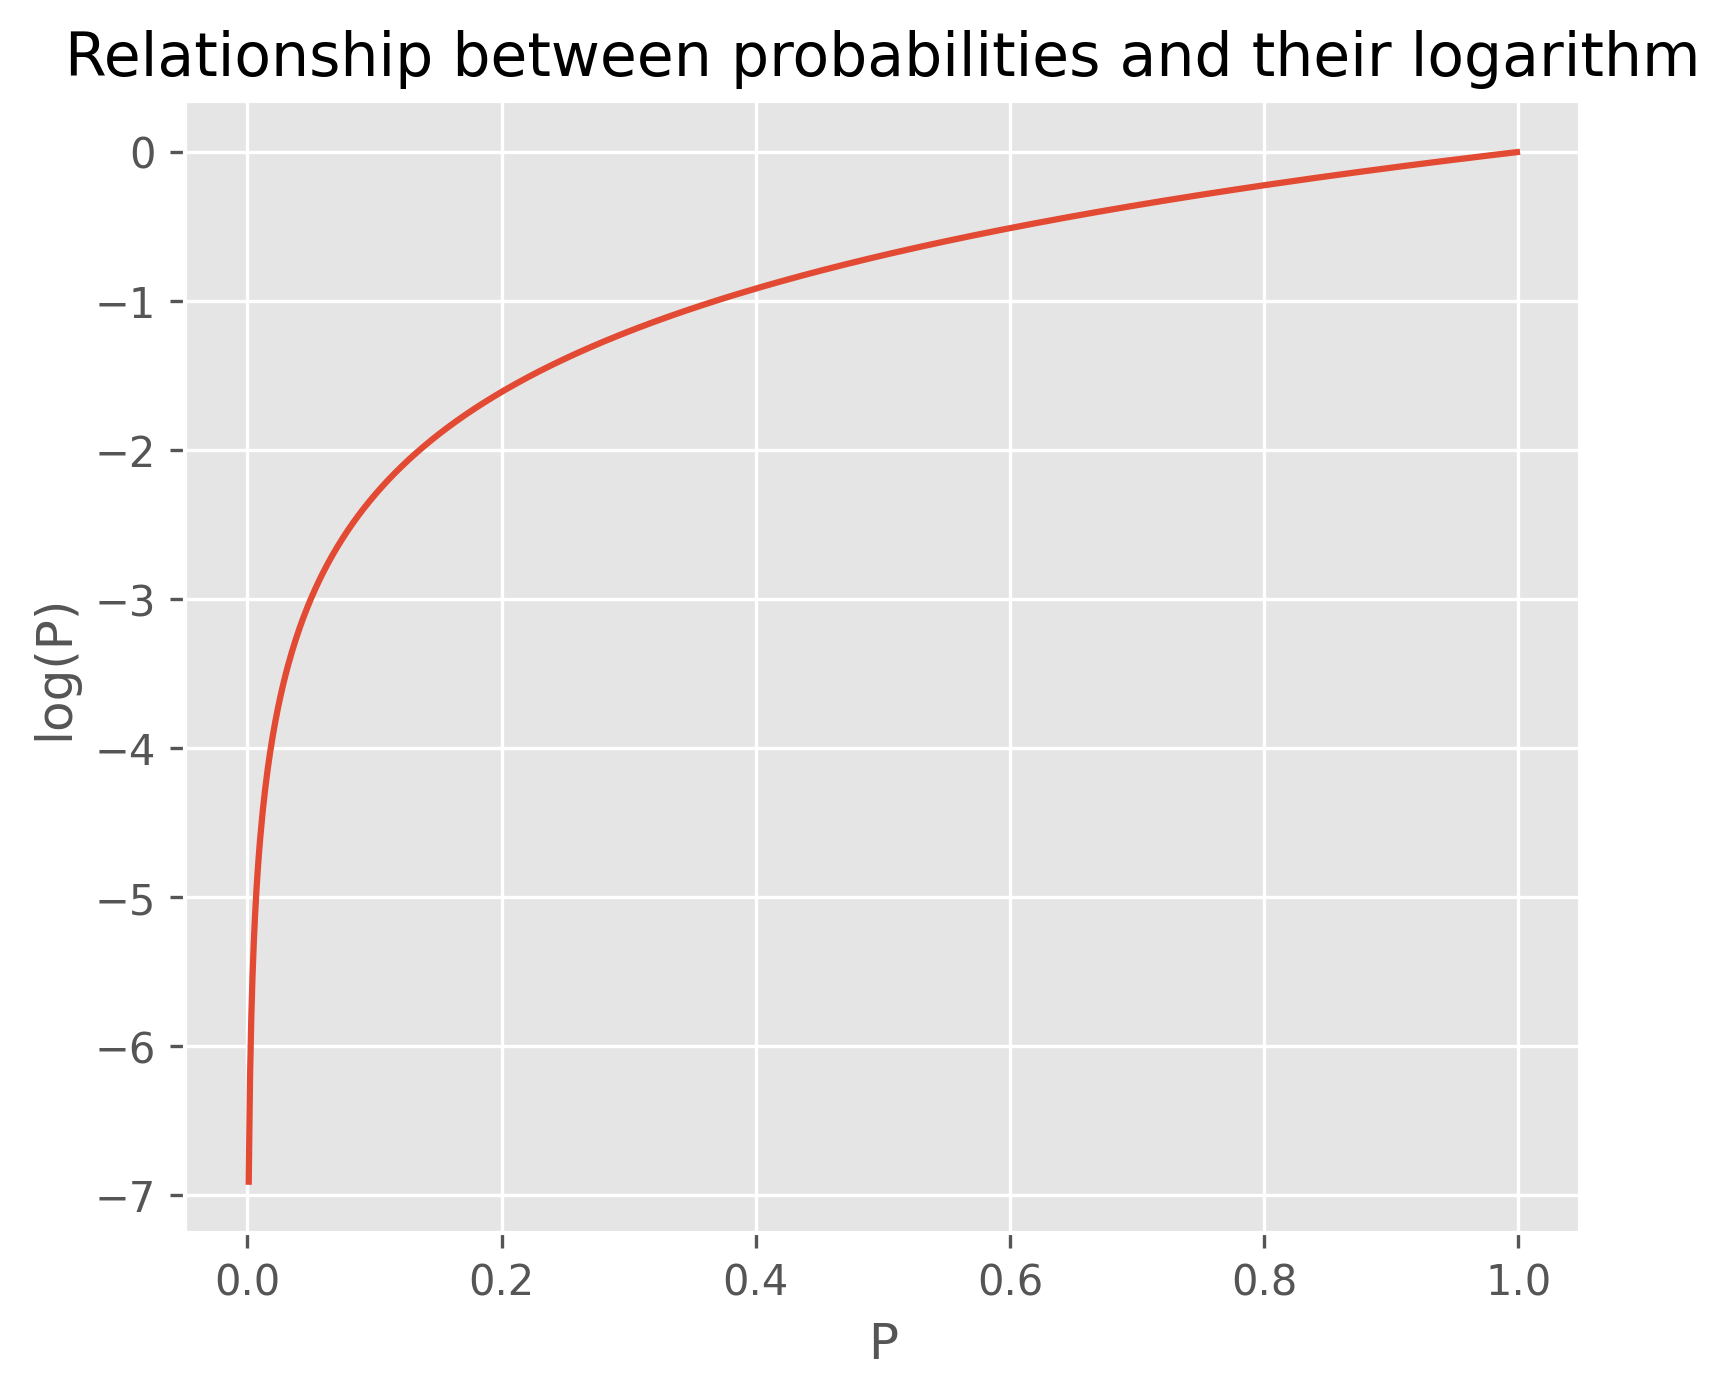

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_log():
    plt.clf()
    DPI = 300
    plt.figure(num=None, figsize=(6, 5), dpi=DPI)

    x = np.arange(0.001, 1, 0.001)
    y = np.log(x)

    plt.title('Relationship between probabilities and their logarithm')
    plt.plot(x, y)
    plt.grid(True)
    plt.xlabel('P')
    plt.ylabel('log(P)')
    plt.show()

plot_log()

There is one caveat though: actually there is no log in the formula's nominator (the top part of the fraction). There is only the product of the probabilities. In this case,  luckily, the actual value of the probabilities is not needed. The goal is to know which class has the highest posterior probability. It is a luck, because if the following is found:
# ![Highest posterior probability](./Highest%20posterior%20probability.PNG)

Then there will always also:
# ![Highest posterior probability with log](./Highest%20posterior%20probability%20with%20log.PNG)

A quick look at the preceding graph shows that the curve is strictly monotonically increasing, that is, it always goes up, when it goes from left to right. Stick this into the aforementioned formula:
# ![Naive Bayes classification formula example for the best class](./Naive%20Bayes%20classification%20formula%20example%20for%20the%20best%20class.PNG)

This will finally retrieve the formula for two features that will give the best class, also for the real-world data that will be seen in practice:
# ![Naive Bayes classification formula example for the best class with log](./Naive%20Bayes%20classification%20formula%20example%20for%20the%20best%20class%20with%20log.PNG)

Of course, it will not be very successful with only two features, so rewrite it to allow for an arbitrary number of features:
# ![Naive Bayes classification formula for the best class with log](./Naive%20Bayes%20classification%20formula%20for%20the%20best%20class%20with%20log.PNG)

There it is, ready to use the first classifier from the scikit-learn toolkit.

As mentioned earlier, the Bernoulli model of Naïve Bayes was just learned. Instead of having Boolean features, the number of word occurrences can be also used, also known as the
Multinomial model. As this provides more information, and often also results in better performance, this will be used for the real-world data. Note, however, that the underlying
formulas change a bit. However, no worries, as the general idea of how Naïve Bayes works is still the same.

## Creating the first classifier and tuning it

The Naïve Bayes classifiers reside in the sklearn.naive_bayes package. There are different kinds of Naïve Bayes classifiers:
* GaussianNB: This classifier assumes the features to be normally distributed (Gaussian). In this case, tweet texts are given from which word counts are extracted. These are clearly not Gaussian-distributed.
* MultinomialNB: This classifier assumes the features to be occurrence counts, which is this case going forward, since word counts will be used in the tweets as features. In
practice, this classifier also works well with TF-IDF vectors.
* BernoulliNB: This classifier is similar to MultinomialNB, but more suited when using binary word occurrences and not word counts.

As the word occurrences will be mainly looked at, the MultinomialNB classifier is best suited for this purpose.

### Solving an easy problem first

As it has been seen, when looked at the tweet data, the tweets are not only positive or negative. To not complicate the task too much, only focus on the positive and negative tweets for now:

In [6]:
# first create a Boolean list having true for tweets
# that are either positive or negative
pos_neg_idx = np.logical_or(Y_orig == "positive", Y_orig == "negative")
# now use that index to filter the data and the labels
X = X_orig[pos_neg_idx]
Y = Y_orig[pos_neg_idx]
# finally convert the labels themselves into Boolean
Y = Y == "positive"

Now, the raw tweet text is obtained in X and the binary classification in Y, 0 for negative and 1 for positive tweets.

Word-occurrence counts will be used as features. They will not be used in their raw form, though. Instead, TfidfVectorizer will be used to convert the raw tweet text into TF-IDF
feature values, which then use together with the labels to train the first classifier. For convenience, the Pipeline class will be used, which allows to hook the vectorizer and the classifier together and provides the same interface:

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

def create_ngram_model(params=None):
    tfidf_ngrams = TfidfVectorizer(ngram_range=(1, 3), analyzer="word", binary=False)
    clf = MultinomialNB()
    pipeline = Pipeline([('tfidf', tfidf_ngrams), ('clf', clf)])
    if params:
        pipeline.set_params(**params)
    return pipeline

The Pipeline instance returned by create_ngram_model() can now be used to fit and predict as if a normal classifier is used. Later, a dictionary of parameters will be passed as params, which will help to create custom pipelines.

Since there is not that much data, cross-validation should be done. This time, however, KFold will not be used, which partitions the data in consecutive folds; instead, ShuffleSplit'll be used. It shuffles the data but does not prevent the same data instance from being in multiple folds. For each fold, then, keep track of the area under the Precision-Recall curve and for accuracy.

To keep the experimentation agile, wrap everything together in a train_model() function, which takes a function as a parameter that creates the classifier:

In [8]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import ShuffleSplit

def train_model(clf_factory, X, Y):
    # setting random_state to get deterministic behavior
    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
    scores = []
    pr_scores = []
    precisions = []
    recalls = []
    for train, test in cv.split(X, Y):
        X_train, y_train = X[train], Y[train]
        X_test, y_test = X[test], Y[test]
        clf = clf_factory()
        clf.fit(X_train, y_train)
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        scores.append(test_score)
        proba = clf.predict_proba(X_test)
        precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:, 1])
        pr_scores.append(auc(recall, precision))
        precisions.append(precision)
        recalls.append(recall)
        summary = (np.mean(scores), np.mean(pr_scores))
        print("Mean acc={:.3f}\tMean P/R AUC={:.3f}".format(summary[0], summary[1]))
    scores_to_sort = pr_scores
    median = np.argsort(scores_to_sort)[len(scores_to_sort) // 2]
    return pr_scores, precisions, recalls, median

Putting everything together, the first model can be trained:

In [9]:
X_orig, Y_orig = load_sanders_data()
pos_neg_idx = np.logical_or(Y_orig == "positive", Y_orig == "negative")
X = X_orig[pos_neg_idx]
Y = Y_orig[pos_neg_idx]
Y = Y == "positive"
pr_scores, precisions, recalls, median = train_model(create_ngram_model, X, Y)

Mean acc=0.783	Mean P/R AUC=0.905
Mean acc=0.794	Mean P/R AUC=0.892
Mean acc=0.776	Mean P/R AUC=0.880
Mean acc=0.774	Mean P/R AUC=0.883
Mean acc=0.773	Mean P/R AUC=0.886
Mean acc=0.772	Mean P/R AUC=0.886
Mean acc=0.777	Mean P/R AUC=0.881
Mean acc=0.785	Mean P/R AUC=0.885
Mean acc=0.784	Mean P/R AUC=0.885
Mean acc=0.783	Mean P/R AUC=0.883


With the first try using Naïve Bayes on vectorized TF-IDF trigram features, an accuracy of 78.3% and an average P/R AUC of 88.3% are obtained. Looking at the P/R chart of the median (the train/test split that is performing most similarly to the average), it shows a much more encouraging behavior than the plots that have been seen in the previous chapter. Please note that the AUC of the plot of 0.89 is slightly different than the mean P/R of 0.883, since the plot is taken from the median training run, whereas the mean P/R AUC averages over all AUC scores. The same principle applies for subsequent images:

<Figure size 432x288 with 0 Axes>

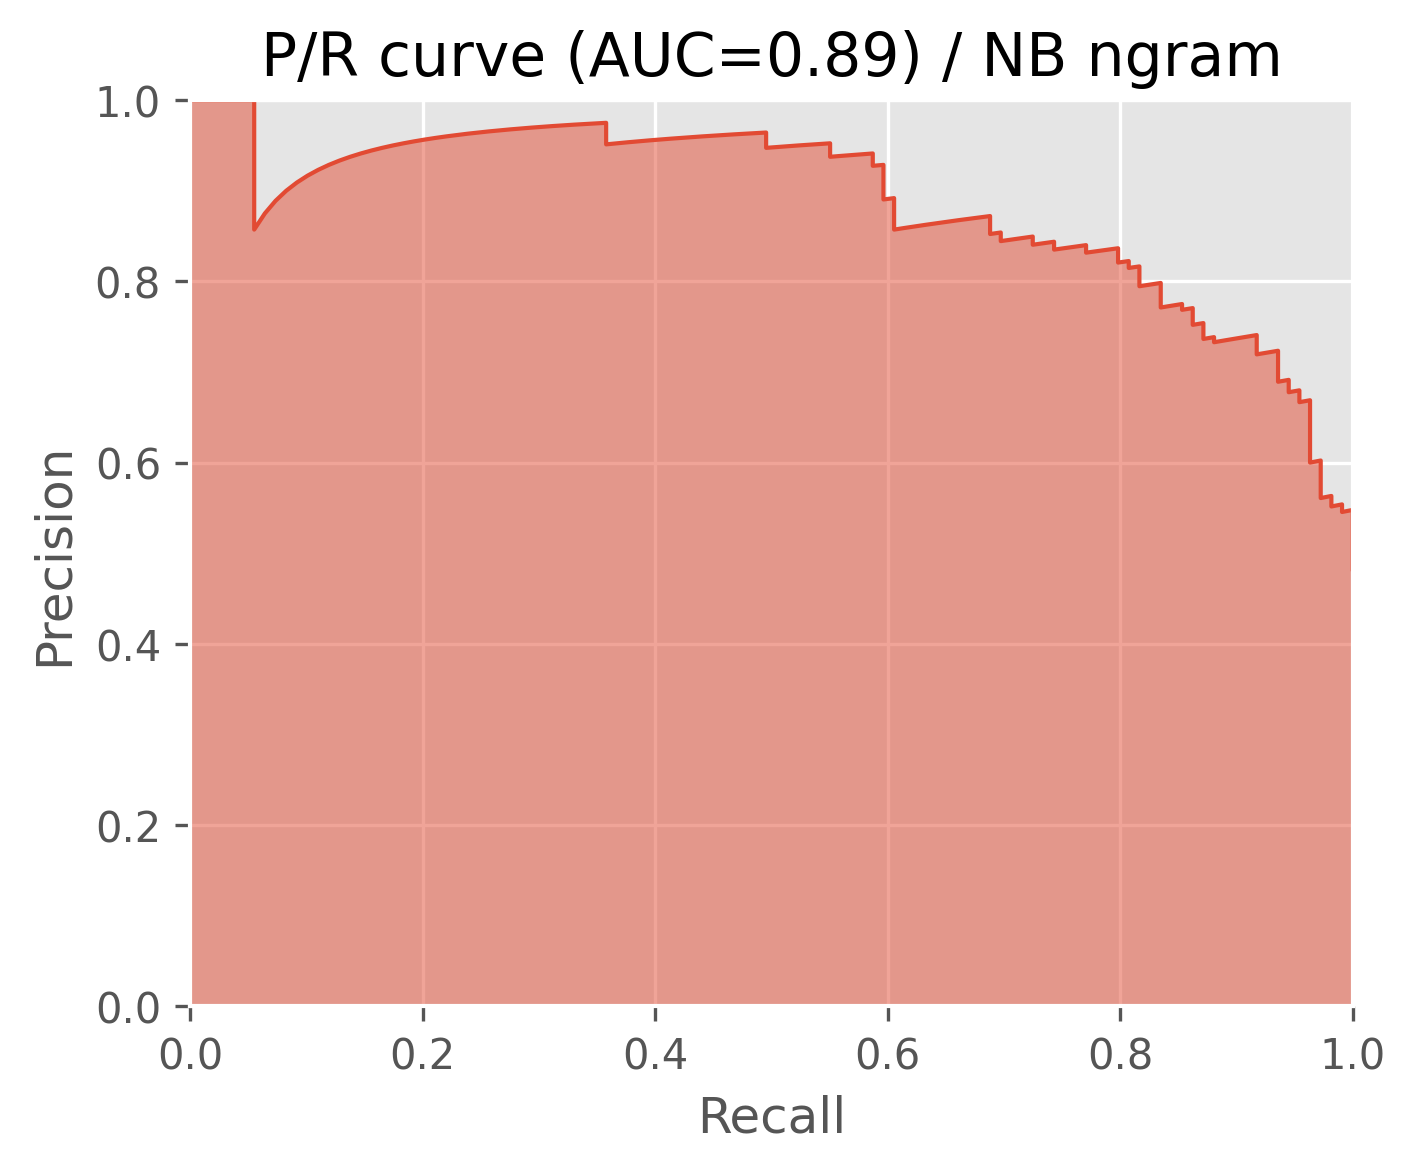

In [10]:
def plot_pr(auc_score, precision, recall, label=None):
    DPI = 300
    plt.clf()
    plt.figure(num=None, figsize=(5, 4), dpi=DPI)
    plt.grid(True)
    plt.fill_between(recall, precision, alpha=0.5)
    plt.plot(recall, precision, lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('P/R curve (AUC={:0.2f}) / {}'.format(auc_score, label))
    plt.show()

plot_pr(pr_scores[median], precisions[median], recalls[median], label="NB ngram")

For a start, the results are quite encouraging. They get even more impressive when realize that 100% accuracy is probably never achievable in a sentiment-classification task. For some tweets, even humans often do not really agree on the same classification label.

### Using all classes

Once again, the task was simplified a bit, since only positive or negative tweets were used. That means, it assumed a perfect classifier that classified upfront whether the tweet contains a sentiment and forwarded that to the Naïve Bayes classifier.

So, how well does it perform if whether a tweet contains any sentiments at all is also classified? To find that out, first write a convenience function that returns a modified class array that provides a list of sentiments that will be interpreted as positive:

In [11]:
def tweak_labels(Y, pos_sent_list):
    pos = Y == pos_sent_list[0]
    for sent_label in pos_sent_list[1:]:
        pos |= Y == sent_label
    Y = np.zeros(Y.shape[0])
    Y[pos] = 1
    return Y.astype(int)

Note that there are two different positives now. The sentiment of a tweet can be positive, which is to be distinguished from the class of the training data. If, for example, the goal is to find out how well tweets having a sentiment can be separateed from neutral ones, it could be done:

In [12]:
X = X_orig
Y = tweak_labels(Y_orig, ["positive", "negative"])

In Y now there is 1 (positive class) for all tweets that are either positive or negative and 0 (negative class) for neutral and irrelevant ones:

In [13]:
pr_scores, precisions, recalls, median = train_model(create_ngram_model, X, Y)

Mean acc=0.733	Mean P/R AUC=0.693
Mean acc=0.716	Mean P/R AUC=0.703
Mean acc=0.722	Mean P/R AUC=0.699
Mean acc=0.721	Mean P/R AUC=0.703
Mean acc=0.719	Mean P/R AUC=0.702
Mean acc=0.724	Mean P/R AUC=0.701
Mean acc=0.723	Mean P/R AUC=0.700
Mean acc=0.724	Mean P/R AUC=0.695
Mean acc=0.723	Mean P/R AUC=0.694
Mean acc=0.723	Mean P/R AUC=0.696


Have a look at the following plot:

<Figure size 432x288 with 0 Axes>

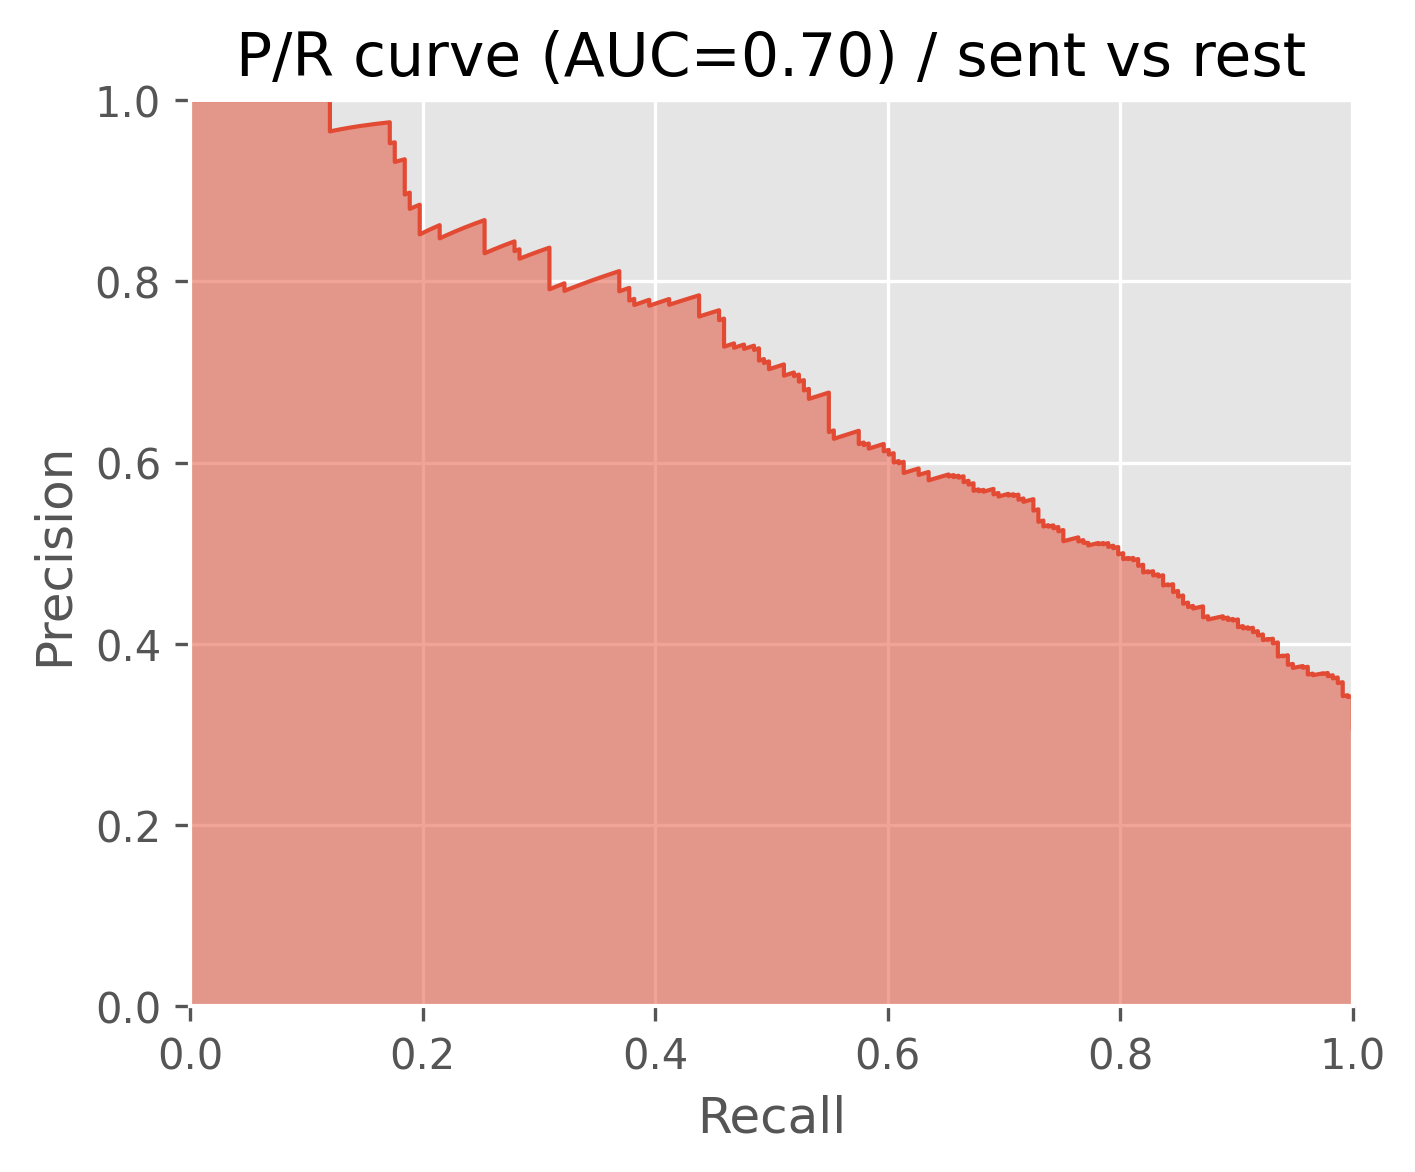

In [14]:
plot_pr(pr_scores[median], precisions[median], recalls[median], label="sent vs rest")

As expected, P/R AUC drops considerably, being only 70% now. The accuracy is still high, but that is only due to the fact that there is a highly imbalanced dataset. Out of 2,530 total tweets, only 752 are either positive or negative, which is about 30%. This means, if a classifier that always classifies a tweet as not containing any sentiments is created, it will already has an accuracy of 70%. This is another reason to always look at precision and recall if the training and test data is unbalanced.

So, how will the Naïve Bayes classifier perform on classifying positive tweets versus the rest, and negative tweets versus the rest? One word: poorly:

In [15]:
print("== Pos vs. rest ==")
X = X_orig
Y = tweak_labels(Y_orig, ["positive"])
pr_scores, precisions, recalls, median = train_model(create_ngram_model, X, Y)

== Pos vs. rest ==
Mean acc=0.876	Mean P/R AUC=0.300
Mean acc=0.869	Mean P/R AUC=0.307
Mean acc=0.866	Mean P/R AUC=0.356
Mean acc=0.865	Mean P/R AUC=0.378
Mean acc=0.863	Mean P/R AUC=0.371
Mean acc=0.866	Mean P/R AUC=0.360
Mean acc=0.865	Mean P/R AUC=0.361
Mean acc=0.864	Mean P/R AUC=0.357
Mean acc=0.865	Mean P/R AUC=0.352
Mean acc=0.864	Mean P/R AUC=0.354


<Figure size 432x288 with 0 Axes>

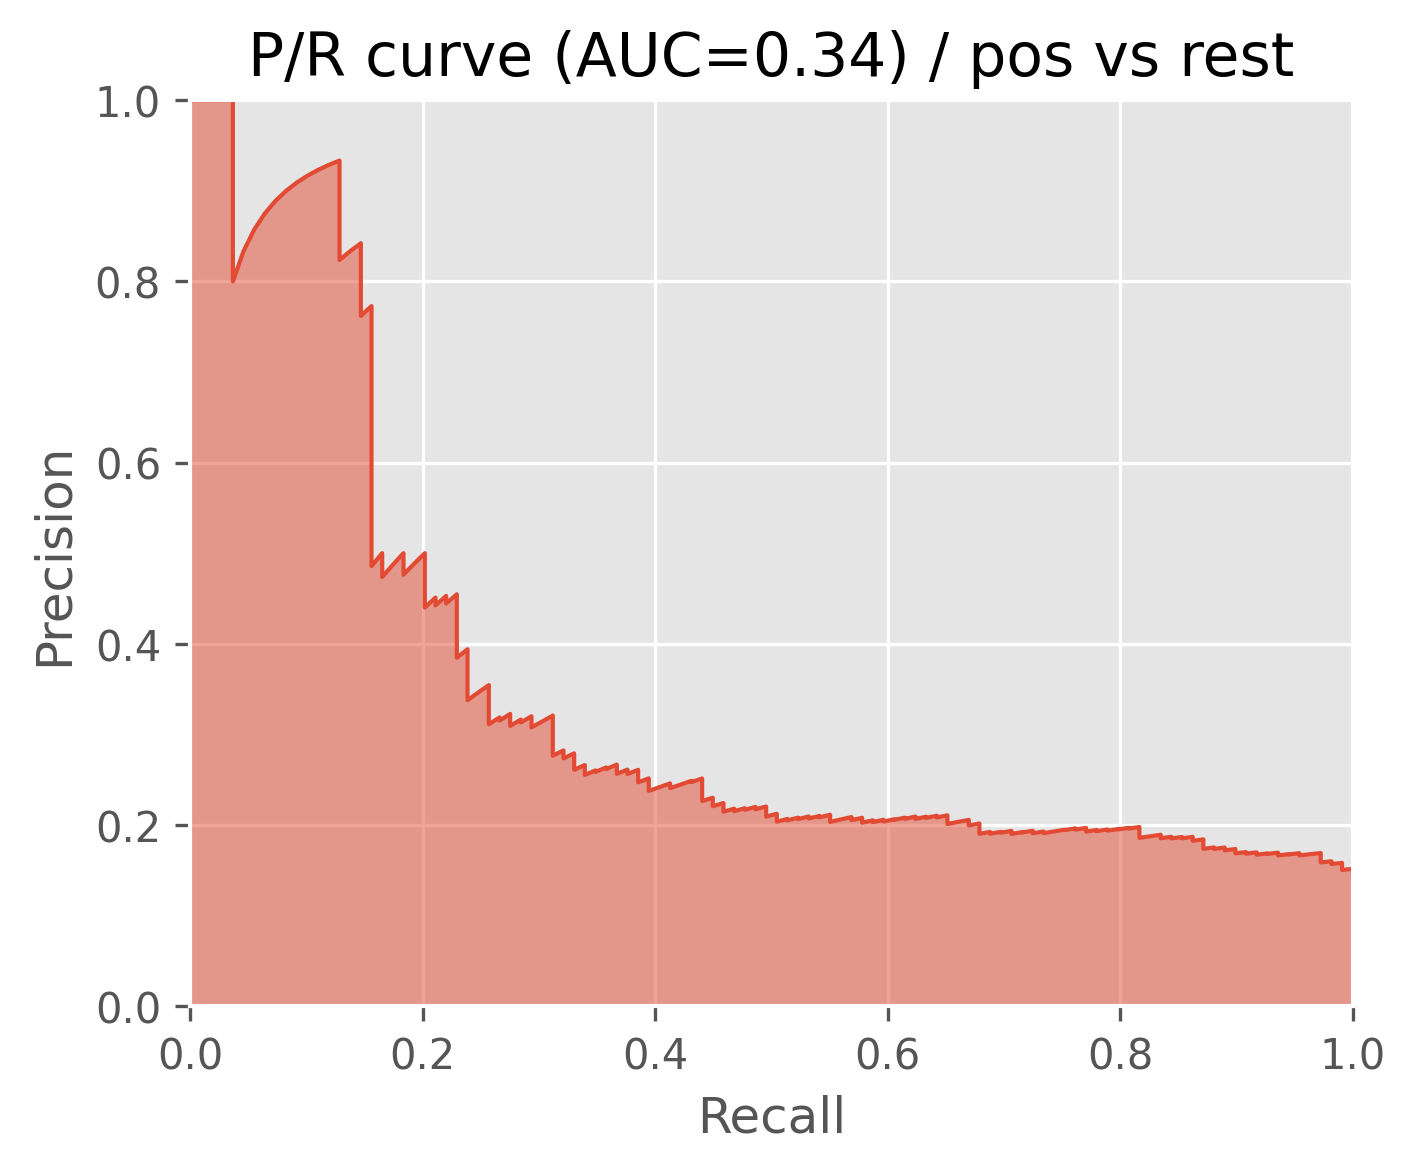

In [16]:
plot_pr(pr_scores[median], precisions[median], recalls[median], label="pos vs rest")

In [17]:
print("== Neg vs. rest ==")
X = X_orig
Y = tweak_labels(Y_orig, ["negative"])
pr_scores, precisions, recalls, median = train_model(create_ngram_model, X, Y)

== Neg vs. rest ==
Mean acc=0.839	Mean P/R AUC=0.559
Mean acc=0.832	Mean P/R AUC=0.559
Mean acc=0.839	Mean P/R AUC=0.565
Mean acc=0.836	Mean P/R AUC=0.567
Mean acc=0.837	Mean P/R AUC=0.556
Mean acc=0.837	Mean P/R AUC=0.552
Mean acc=0.836	Mean P/R AUC=0.551
Mean acc=0.838	Mean P/R AUC=0.552
Mean acc=0.836	Mean P/R AUC=0.547
Mean acc=0.837	Mean P/R AUC=0.548


<Figure size 432x288 with 0 Axes>

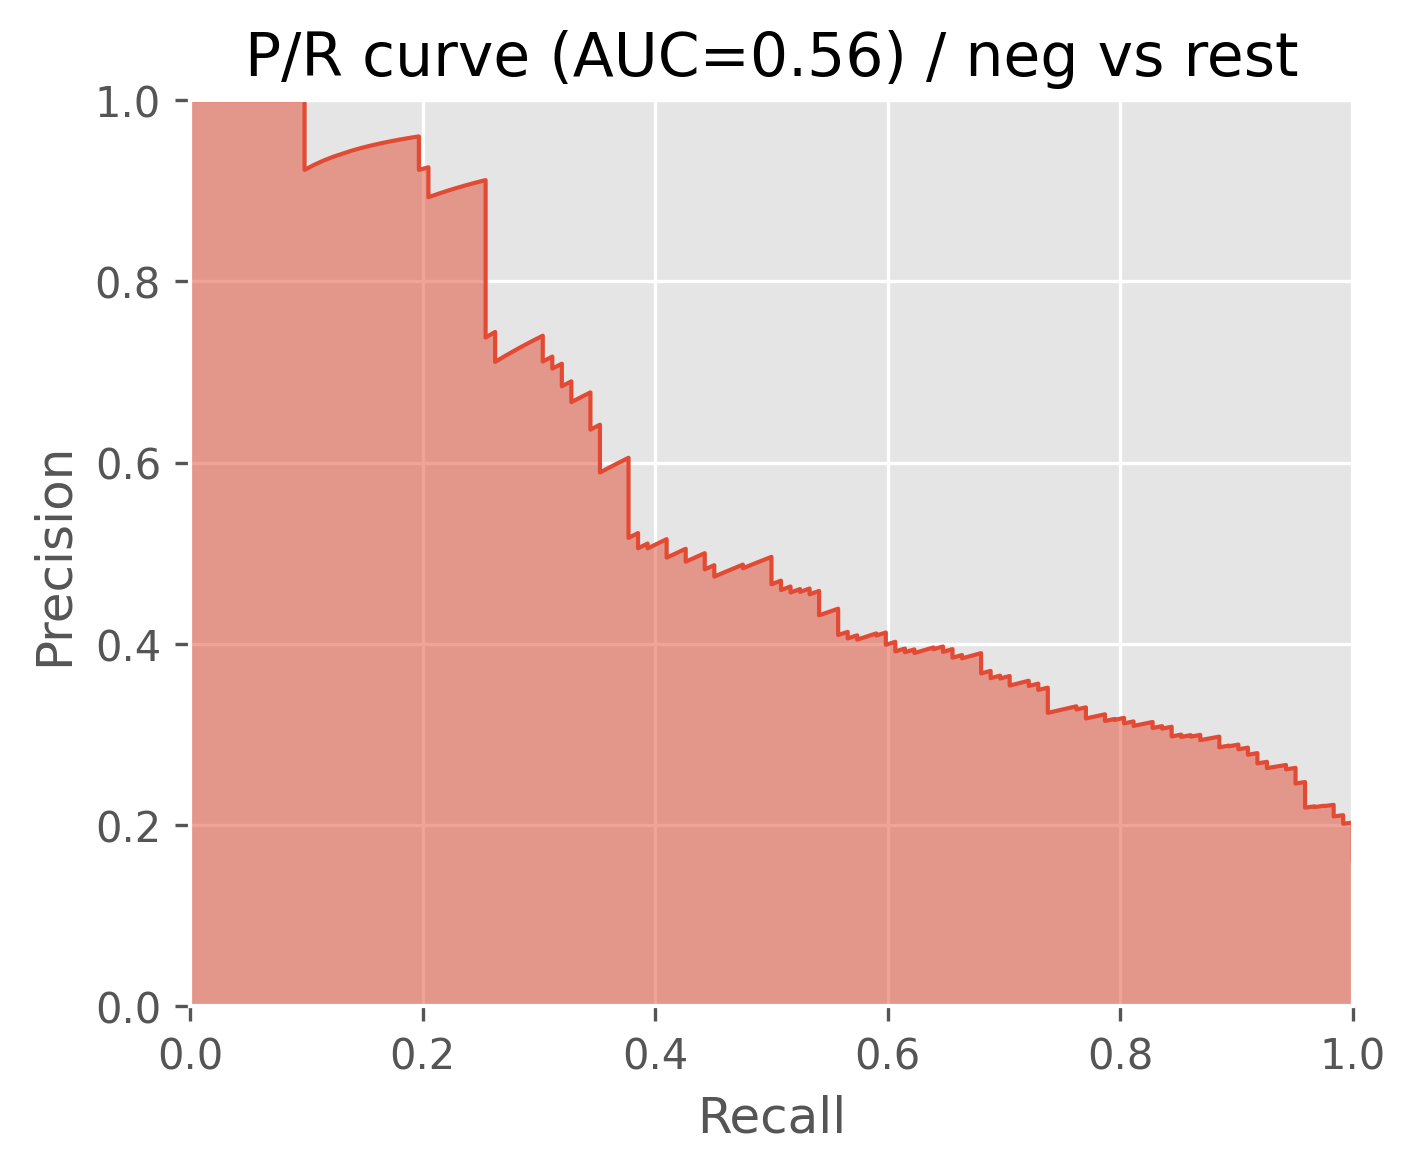

In [18]:
plot_pr(pr_scores[median], precisions[median], recalls[median], label="neg vs rest")

Pretty unusable. Looking at the P/R curves in the previous plots, no usable precision/recall trade-off will be also found.

### Tuning the classifier's parameters

Certainly, the current setup has not been explored enough and should investigate more. There are roughly two areas where the knobs can be played with: TfidfVectorizer and MultinomialNB. As there is no real intuition in which area it should be explored, try to sweep the hyperparameters.

The TfidfVectorizer parameter will be seen first:
* Using different settings for ngrams:
1. unigrams (1,1)
2. unigrams and bigrams (1,2)
3. unigrams, bigrams, and trigrams (1,3)
* Playing with min_df: 1 or 2
* Exploring the impact of IDF within TF-IDF using use_idf and smooth_idf: False or True
* Whether to remove stop words or not, by setting stop_words to english or None
* Whether to use the logarithm of the word counts (sublinear_tf)
* Whether to track word counts or simply track whether words occur or not, by setting binary to True or False

Now the MultinomialNB classifier will be seen:
* Which smoothing method to use by setting alpha
* Add-one or Laplace smoothing: 1
* Lidstone smoothing: 0.01, 0.05, 0.1, or 0.5
* No smoothing: 0

A simple approach could be to train a classifier for all those reasonable exploration values, while keeping the other parameters constant and check the classifier's results. As it is not known whether those parameters affect each other, doing it right will require that a classifier is trained for every possible combination of all parameter values. Obviously, this is too tedious.

Because this kind of parameter exploration occurs frequently in machine learning tasks, scikit-learn has a dedicated class for it, called GridSearchCV. It takes an estimator (instance with a classifier-like interface), which will be the Pipeline instance in this case, and a dictionary of parameters with their potential values.

GridSearchCV expects the dictionary's keys to obey a certain format so that it is able to set the parameters of the correct estimator. The format is as follows:
<estimator>__<subestimator>__...__<param_name>

For example, if the desired values want to be specified to explore for the ngram_range parameter of TfidfVectorizer (named tfidf in the Pipeline description), it would be:

In [19]:
param_grid = {"tfidf__ngram_range": [(1, 1), (1, 2), (1, 3)]}

This will tell GridSearchCV to try out unigrams to trigrams as parameter values for the ngram_range parameter of TfidfVectorizer.

Then, it trains the estimator with all possible parameter-value combinations. Make sure that it trains on random samples of the training data using ShuffleSplit, which generates an iterator of random train/test splits. Finally, it provides the best estimator in the form of the member variable, best_estimator_.

As the goal is to compare the returned best classifier with the current best one, it needs to be evaluated in the same way. Therefore, the ShuffleSplit instance can be passed using the cv parameter (therefore, CV in GridSearchCV).

The last missing piece is to define how GridSearchCV should determine the best estimator. This can be done by providing the desired score function to the scoring parameter, using the make_scorer helper function. metric.accuracy should certainly not be taken because of the class imbalance (there is a lot fewer tweets containing sentiments than neutral ones). Instead, the goal is to have good precision and recall on both classes, tweets with sentiment and tweets without positive or negative opinions. One metric that combines both precision and recall is the F-measure, which is implemented as metrics.f1_score:
# ![F1 score formula](./F1%20score%20formula.PNG)

After putting everything together, the following code is obtianed:

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

def grid_search_model(clf_factory, X, Y):
    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
    param_grid = dict(
        tfidf__ngram_range = [(1, 1), (1, 2), (1, 3)],
        tfidf__min_df = [1, 2],
        tfidf__stop_words  = [None, "english"],
        tfidf__smooth_idf = [False, True],
        tfidf__use_idf = [False, True],
        tfidf__sublinear_tf = [False, True],
        tfidf__binary = [False, True],
        clf__alpha = [0, 0.01, 0.05, 0.1, 0.5, 1],
    )
    grid_search = GridSearchCV(clf_factory(), param_grid=param_grid, cv=cv, scoring=make_scorer(f1_score), verbose=10)
    grid_search.fit(X, Y)
    return grid_search.best_estimator_

Be patient while executing this:

In [21]:
print("== Pos/neg vs. irrelevant/neutral ==")
X = X_orig
Y = tweak_labels(Y_orig, ["positive", "negative"])
clf = grid_search_model(create_ngram_model, X, Y)

== Pos/neg vs. irrelevant/neutral ==
Fitting 10 folds for each of 1152 candidates, totalling 11520 fits
[CV 1/10; 1/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 1/10; 1/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.533 total time=   0.0s
[CV 2/10; 1/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/10; 1/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.552 total time=   0.0s
[CV 3/10; 1/1152] START clf__alpha

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 6/10; 1/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.533 total time=   0.0s
[CV 7/10; 1/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 7/10; 1/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.528 total time=   0.0s
[CV 8/10; 1/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 8/10; 1/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 2/10; 2/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.536 total time=   0.0s
[CV 3/10; 2/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/10; 2/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.557 total time=   0.0s
[CV 4/10; 2/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 4/10; 2/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 8/10; 2/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.520 total time=   0.0s
[CV 9/10; 2/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 2/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.592 total time=   0.0s
[CV 10/10; 2/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 10/10; 2/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_wo

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 4/10; 3/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.567 total time=   0.0s
[CV 5/10; 3/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/10; 3/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.553 total time=   0.0s
[CV 6/10; 3/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 6/10; 3/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 10/10; 3/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.583 total time=   0.0s
[CV 1/10; 4/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/10; 4/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.539 total time=   0.0s
[CV 2/10; 4/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 4/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 6/10; 4/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.536 total time=   0.0s
[CV 7/10; 4/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 7/10; 4/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.524 total time=   0.0s
[CV 8/10; 4/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 8/10; 4/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=No

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 2/10; 5/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.533 total time=   0.0s
[CV 3/10; 5/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 5/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.549 total time=   0.0s
[CV 4/10; 5/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 4/10; 5/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, 

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 8/10; 5/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.510 total time=   0.0s
[CV 9/10; 5/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 9/10; 5/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.566 total time=   0.0s
[CV 10/10; 5/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 10/10; 5/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 4/10; 6/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.562 total time=   0.0s
[CV 5/10; 6/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 5/10; 6/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.575 total time=   0.0s
[CV 6/10; 6/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 6/10; 6/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 10/10; 6/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.586 total time=   0.0s
[CV 1/10; 7/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/10; 7/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.569 total time=   0.0s
[CV 2/10; 7/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/10; 7/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfi

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 6/10; 7/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.527 total time=   0.0s
[CV 7/10; 7/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 7/10; 7/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.537 total time=   0.0s
[CV 8/10; 7/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 8/10; 7/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 2/10; 8/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.540 total time=   0.0s
[CV 3/10; 8/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 3/10; 8/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.564 total time=   0.0s
[CV 4/10; 8/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 4/10; 8/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__s

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 8/10; 8/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.519 total time=   0.0s
[CV 9/10; 8/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 9/10; 8/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.578 total time=   0.0s
[CV 10/10; 8/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 10/10; 8/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 4/10; 9/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.567 total time=   0.0s
[CV 5/10; 9/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/10; 9/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.545 total time=   0.0s
[CV 6/10; 9/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 6/10; 9/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 10/10; 9/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.583 total time=   0.0s
[CV 1/10; 10/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/10; 10/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.550 total time=   0.0s
[CV 2/10; 10/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/10; 10/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_wor

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 6/10; 10/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.554 total time=   0.0s
[CV 7/10; 10/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 7/10; 10/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.517 total time=   0.0s
[CV 8/10; 10/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 8/10; 10/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 2/10; 11/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.551 total time=   0.0s
[CV 3/10; 11/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/10; 11/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.554 total time=   0.0s
[CV 4/10; 11/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 4/10; 11/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 8/10; 11/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.501 total time=   0.0s
[CV 9/10; 11/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 9/10; 11/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.578 total time=   0.0s
[CV 10/10; 11/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 10/10; 11/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_wo

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 4/10; 12/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.576 total time=   0.0s
[CV 5/10; 12/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/10; 12/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.553 total time=   0.0s
[CV 6/10; 12/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 6/10; 12/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=No

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 10/10; 12/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.586 total time=   0.0s
[CV 1/10; 13/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 1/10; 13/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.567 total time=   0.0s
[CV 2/10; 13/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/10; 13/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 2/10; 14/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.543 total time=   0.0s
[CV 3/10; 14/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/10; 14/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.561 total time=   0.0s
[CV 4/10; 14/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 4/10; 14/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 8/10; 14/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.524 total time=   0.0s
[CV 9/10; 14/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 14/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.579 total time=   0.0s
[CV 10/10; 14/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 10/10; 14/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tf

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 4/10; 15/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.565 total time=   0.0s
[CV 5/10; 15/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/10; 15/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.565 total time=   0.0s
[CV 6/10; 15/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 6/10; 15/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 10/10; 15/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.576 total time=   0.0s
[CV 1/10; 16/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/10; 16/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.554 total time=   0.0s
[CV 2/10; 16/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 16/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 6/10; 16/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.530 total time=   0.0s
[CV 7/10; 16/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 7/10; 16/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.531 total time=   0.0s
[CV 8/10; 16/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 8/10; 16/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__s

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 17/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.577 total time=   0.0s
[CV 2/10; 17/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/10; 17/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.567 total time=   0.0s
[CV 3/10; 17/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 17/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 17/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.602 total time=   0.0s
[CV 5/10; 17/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/10; 17/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.577 total time=   0.0s
[CV 6/10; 17/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 6/10; 17/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 17/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.565 total time=   0.0s
[CV 8/10; 17/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 8/10; 17/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.517 total time=   0.0s
[CV 9/10; 17/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 9/10; 17/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 17/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.583 total time=   0.0s
[CV 1/10; 18/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/10; 18/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.567 total time=   0.0s
[CV 2/10; 18/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/10; 18/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__st

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 18/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.550 total time=   0.0s
[CV 4/10; 18/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 4/10; 18/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.600 total time=   0.0s
[CV 5/10; 18/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 5/10; 18/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 18/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.582 total time=   0.0s
[CV 7/10; 18/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 7/10; 18/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.574 total time=   0.0s
[CV 8/10; 18/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 8/10; 18/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 18/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.553 total time=   0.0s
[CV 10/10; 18/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 10/10; 18/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.578 total time=   0.0s
[CV 1/10; 19/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/10; 19/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__st

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 19/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.567 total time=   0.0s
[CV 3/10; 19/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/10; 19/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.533 total time=   0.0s
[CV 4/10; 19/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 4/10; 19/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 19/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.577 total time=   0.0s
[CV 6/10; 19/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 6/10; 19/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.589 total time=   0.0s
[CV 7/10; 19/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 7/10; 19/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 19/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.521 total time=   0.0s
[CV 9/10; 19/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 9/10; 19/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.553 total time=   0.0s
[CV 10/10; 19/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 10/10; 19/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__st

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 20/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.569 total time=   0.0s
[CV 2/10; 20/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 20/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.557 total time=   0.0s
[CV 3/10; 20/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 3/10; 20/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_wor

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 20/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.600 total time=   0.0s
[CV 5/10; 20/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/10; 20/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.556 total time=   0.0s
[CV 6/10; 20/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 6/10; 20/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_wor

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 20/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.575 total time=   0.0s
[CV 8/10; 20/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 8/10; 20/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.516 total time=   0.0s
[CV 9/10; 20/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 9/10; 20/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_wor

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 20/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.578 total time=   0.0s
[CV 1/10; 21/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 1/10; 21/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.582 total time=   0.0s
[CV 2/10; 21/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/10; 21/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 21/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.573 total time=   0.0s
[CV 5/10; 21/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/10; 21/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.585 total time=   0.0s
[CV 6/10; 21/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 6/10; 21/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=Fa

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 21/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.528 total time=   0.0s
[CV 9/10; 21/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 9/10; 21/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.561 total time=   0.0s
[CV 10/10; 21/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 10/10; 21/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 22/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.542 total time=   0.0s
[CV 3/10; 22/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/10; 22/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.587 total time=   0.0s
[CV 4/10; 22/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 4/10; 22/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 22/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.567 total time=   0.0s
[CV 7/10; 22/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 7/10; 22/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.563 total time=   0.0s
[CV 8/10; 22/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 8/10; 22/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 22/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.617 total time=   0.0s
[CV 1/10; 23/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/10; 23/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.583 total time=   0.0s
[CV 2/10; 23/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/10; 23/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 23/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.575 total time=   0.0s
[CV 5/10; 23/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/10; 23/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.588 total time=   0.0s
[CV 6/10; 23/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 6/10; 23/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 23/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.532 total time=   0.0s
[CV 9/10; 23/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 9/10; 23/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.557 total time=   0.0s
[CV 10/10; 23/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 10/10; 23/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=Fals

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 24/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.542 total time=   0.0s
[CV 3/10; 24/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 3/10; 24/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.587 total time=   0.0s
[CV 4/10; 24/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 4/10; 24/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfi

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 24/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.584 total time=   0.0s
[CV 6/10; 24/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 6/10; 24/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.567 total time=   0.0s
[CV 7/10; 24/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 7/10; 24/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfi

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 24/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.568 total time=   0.0s
[CV 10/10; 24/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 10/10; 24/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.618 total time=   0.0s
[CV 1/10; 25/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 1/10; 25/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 25/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.567 total time=   0.0s
[CV 3/10; 25/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 25/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.534 total time=   0.0s
[CV 4/10; 25/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 4/10; 25/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 25/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.577 total time=   0.0s
[CV 6/10; 25/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 6/10; 25/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.589 total time=   0.0s
[CV 7/10; 25/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 7/10; 25/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 25/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.517 total time=   0.0s
[CV 9/10; 25/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 9/10; 25/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.556 total time=   0.0s
[CV 10/10; 25/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 10/10; 25/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__sto

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 26/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.569 total time=   0.0s
[CV 2/10; 26/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/10; 26/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.557 total time=   0.0s
[CV 3/10; 26/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/10; 26/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 26/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.600 total time=   0.0s
[CV 5/10; 26/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 5/10; 26/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.559 total time=   0.0s
[CV 6/10; 26/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 6/10; 26/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 26/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.578 total time=   0.0s
[CV 8/10; 26/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 8/10; 26/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.513 total time=   0.0s
[CV 9/10; 26/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 26/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 26/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.582 total time=   0.0s
[CV 1/10; 27/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/10; 27/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.576 total time=   0.0s
[CV 2/10; 27/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/10; 27/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_wor

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 27/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.589 total time=   0.0s
[CV 7/10; 27/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 7/10; 27/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.560 total time=   0.0s
[CV 8/10; 27/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 8/10; 27/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 27/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.553 total time=   0.0s
[CV 10/10; 27/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 10/10; 27/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.586 total time=   0.0s
[CV 1/10; 28/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/10; 28/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_wor

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 28/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.560 total time=   0.0s
[CV 3/10; 28/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 3/10; 28/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.544 total time=   0.0s
[CV 4/10; 28/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 4/10; 28/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=No

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 28/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.559 total time=   0.0s
[CV 6/10; 28/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 6/10; 28/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.583 total time=   0.0s
[CV 7/10; 28/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 7/10; 28/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=No

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 28/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.510 total time=   0.0s
[CV 9/10; 28/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 9/10; 28/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.554 total time=   0.0s
[CV 10/10; 28/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 10/10; 28/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 29/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.582 total time=   0.0s
[CV 2/10; 29/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/10; 29/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.575 total time=   0.0s
[CV 3/10; 29/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 29/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, 

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 29/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.573 total time=   0.0s
[CV 5/10; 29/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/10; 29/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.585 total time=   0.0s
[CV 6/10; 29/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 6/10; 29/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, 

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 29/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.528 total time=   0.0s
[CV 9/10; 29/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 9/10; 29/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.561 total time=   0.0s
[CV 10/10; 29/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 10/10; 29/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 30/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.550 total time=   0.0s
[CV 3/10; 30/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/10; 30/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.589 total time=   0.0s
[CV 4/10; 30/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 4/10; 30/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 30/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.569 total time=   0.0s
[CV 7/10; 30/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 7/10; 30/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.564 total time=   0.0s
[CV 8/10; 30/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 8/10; 30/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 30/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.610 total time=   0.0s
[CV 1/10; 31/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/10; 31/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.583 total time=   0.0s
[CV 2/10; 31/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/10; 31/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfi

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 31/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.590 total time=   0.0s
[CV 4/10; 31/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 4/10; 31/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.575 total time=   0.0s
[CV 5/10; 31/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/10; 31/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 31/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.571 total time=   0.0s
[CV 7/10; 31/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 7/10; 31/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.577 total time=   0.0s
[CV 8/10; 31/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 8/10; 31/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 31/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.617 total time=   0.0s
[CV 1/10; 32/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/10; 32/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.571 total time=   0.0s
[CV 2/10; 32/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 32/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 32/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.565 total time=   0.0s
[CV 5/10; 32/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/10; 32/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.584 total time=   0.0s
[CV 6/10; 32/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 6/10; 32/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__s

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 32/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.566 total time=   0.0s
[CV 8/10; 32/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 8/10; 32/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.526 total time=   0.0s
[CV 9/10; 32/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 9/10; 32/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__s

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 32/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.612 total time=   0.0s
[CV 1/10; 33/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 1/10; 33/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.573 total time=   0.0s
[CV 2/10; 33/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 33/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.584 total time=   0.0s
[CV 3/10; 33/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 33/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.548 total time=   0.0s
[CV 4/10; 33/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 33/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.602 total time=   0.0s
[CV 5/10; 33/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/10; 33/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.554 total time=   0.0s
[CV 6/10; 33/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 33/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.585 total time=   0.0s
[CV 7/10; 33/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 7/10; 33/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.552 total time=   0.0s
[CV 8/10; 33/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 33/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.533 total time=   0.0s
[CV 9/10; 33/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 9/10; 33/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.560 total time=   0.0s
[CV 10/10; 33/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 33/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.591 total time=   0.0s
[CV 1/10; 34/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/10; 34/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.567 total time=   0.0s
[CV 2/10; 34/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 34/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.571 total time=   0.0s
[CV 3/10; 34/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/10; 34/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.554 total time=   0.0s
[CV 4/10; 34/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 34/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.595 total time=   0.0s
[CV 5/10; 34/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 5/10; 34/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.548 total time=   0.0s
[CV 6/10; 34/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 34/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.576 total time=   0.0s
[CV 7/10; 34/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 7/10; 34/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.557 total time=   0.0s
[CV 8/10; 34/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 34/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.535 total time=   0.0s
[CV 9/10; 34/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 34/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.550 total time=   0.0s
[CV 10/10; 34/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 34/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.584 total time=   0.0s
[CV 1/10; 35/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/10; 35/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.571 total time=   0.0s
[CV 2/10; 35/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 35/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.584 total time=   0.0s
[CV 3/10; 35/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/10; 35/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.543 total time=   0.0s
[CV 4/10; 35/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 35/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.603 total time=   0.0s
[CV 5/10; 35/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/10; 35/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.558 total time=   0.0s
[CV 6/10; 35/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 35/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.587 total time=   0.0s
[CV 7/10; 35/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 7/10; 35/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.549 total time=   0.0s
[CV 8/10; 35/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 35/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.533 total time=   0.0s
[CV 9/10; 35/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 9/10; 35/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.560 total time=   0.0s
[CV 10/10; 35/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 35/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.593 total time=   0.0s
[CV 1/10; 36/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/10; 36/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.564 total time=   0.0s
[CV 2/10; 36/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 36/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.573 total time=   0.0s
[CV 3/10; 36/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 3/10; 36/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.550 total time=   0.0s
[CV 4/10; 36/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 36/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.596 total time=   0.0s
[CV 5/10; 36/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/10; 36/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.548 total time=   0.0s
[CV 6/10; 36/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 36/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.579 total time=   0.0s
[CV 7/10; 36/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 7/10; 36/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.558 total time=   0.0s
[CV 8/10; 36/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 36/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.528 total time=   0.0s
[CV 9/10; 36/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 9/10; 36/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.547 total time=   0.0s
[CV 10/10; 36/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 36/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.584 total time=   0.0s
[CV 1/10; 37/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 1/10; 37/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.581 total time=   0.0s
[CV 2/10; 37/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/10; 37/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 37/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.592 total time=   0.0s
[CV 4/10; 37/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 4/10; 37/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.577 total time=   0.0s
[CV 5/10; 37/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/10; 37/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=Fa

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 37/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.545 total time=   0.0s
[CV 9/10; 37/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 9/10; 37/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.570 total time=   0.0s
[CV 10/10; 37/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 10/10; 37/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 38/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.564 total time=   0.0s
[CV 2/10; 38/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/10; 38/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.548 total time=   0.0s
[CV 3/10; 38/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 38/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.586 total time=   0.0s
[CV 4/10; 38/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 4/10; 38/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.565 total time=   0.0s
[CV 5/10; 38/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 5/10; 38/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 38/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.583 total time=   0.0s
[CV 7/10; 38/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 7/10; 38/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.557 total time=   0.0s
[CV 8/10; 38/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 8/10; 38/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 38/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.566 total time=   0.0s
[CV 10/10; 38/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 10/10; 38/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.615 total time=   0.0s
[CV 1/10; 39/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/10; 39/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=Fals

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 39/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.578 total time=   0.0s
[CV 3/10; 39/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/10; 39/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.593 total time=   0.0s
[CV 4/10; 39/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 4/10; 39/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 39/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.593 total time=   0.0s
[CV 6/10; 39/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 6/10; 39/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.578 total time=   0.0s
[CV 7/10; 39/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 7/10; 39/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 39/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.544 total time=   0.0s
[CV 9/10; 39/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 9/10; 39/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.565 total time=   0.0s
[CV 10/10; 39/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 10/10; 39/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=Fals

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 40/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.566 total time=   0.0s
[CV 2/10; 40/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 40/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.548 total time=   0.0s
[CV 3/10; 40/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 3/10; 40/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfi

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(



[CV 4/10; 40/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.566 total time=   0.0s
[CV 5/10; 40/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/10; 40/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.581 total time=   0.0s
[CV 6/10; 40/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 40/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.582 total time=   0.0s
[CV 7/10; 40/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 7/10; 40/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.559 total time=   0.0s
[CV 8/10; 40/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 8/10; 40/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfi

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 40/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.562 total time=   0.0s
[CV 10/10; 40/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 10/10; 40/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.617 total time=   0.0s
[CV 1/10; 41/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 41/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.573 total time=   0.0s
[CV 2/10; 41/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/10; 41/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.584 total time=   0.0s
[CV 3/10; 41/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 41/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.548 total time=   0.0s
[CV 4/10; 41/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 4/10; 41/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.602 total time=   0.0s
[CV 5/10; 41/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 41/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.554 total time=   0.0s
[CV 6/10; 41/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 6/10; 41/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.585 total time=   0.0s
[CV 7/10; 41/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 41/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.552 total time=   0.0s
[CV 8/10; 41/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 8/10; 41/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.533 total time=   0.0s
[CV 9/10; 41/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 41/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.560 total time=   0.0s
[CV 10/10; 41/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 10/10; 41/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.591 total time=   0.0s
[CV 1/10; 42/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 42/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.571 total time=   0.0s
[CV 2/10; 42/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/10; 42/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.571 total time=   0.0s
[CV 3/10; 42/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 42/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.550 total time=   0.0s
[CV 4/10; 42/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 4/10; 42/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.596 total time=   0.0s
[CV 5/10; 42/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 42/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.547 total time=   0.0s
[CV 6/10; 42/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 6/10; 42/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.578 total time=   0.0s
[CV 7/10; 42/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 42/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.561 total time=   0.0s
[CV 8/10; 42/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 8/10; 42/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.533 total time=   0.0s
[CV 9/10; 42/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 42/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.554 total time=   0.0s
[CV 10/10; 42/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 10/10; 42/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.587 total time=   0.0s
[CV 1/10; 43/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 43/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.571 total time=   0.0s
[CV 2/10; 43/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/10; 43/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.584 total time=   0.0s
[CV 3/10; 43/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 43/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.543 total time=   0.0s
[CV 4/10; 43/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 4/10; 43/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.603 total time=   0.0s
[CV 5/10; 43/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 43/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.558 total time=   0.0s
[CV 6/10; 43/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 6/10; 43/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.587 total time=   0.0s
[CV 7/10; 43/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 43/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.549 total time=   0.0s
[CV 8/10; 43/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 8/10; 43/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.533 total time=   0.0s
[CV 9/10; 43/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 43/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.560 total time=   0.0s
[CV 10/10; 43/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 10/10; 43/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.593 total time=   0.0s
[CV 1/10; 44/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 44/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.571 total time=   0.0s
[CV 2/10; 44/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 44/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.571 total time=   0.0s
[CV 3/10; 44/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 44/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.548 total time=   0.0s
[CV 4/10; 44/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 4/10; 44/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.596 total time=   0.0s
[CV 5/10; 44/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 44/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.547 total time=   0.0s
[CV 6/10; 44/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 6/10; 44/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.580 total time=   0.0s
[CV 7/10; 44/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 44/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.560 total time=   0.0s
[CV 8/10; 44/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 8/10; 44/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.526 total time=   0.0s
[CV 9/10; 44/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 44/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.553 total time=   0.0s
[CV 10/10; 44/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 10/10; 44/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.587 total time=   0.0s
[CV 1/10; 45/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 45/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.581 total time=   0.0s
[CV 2/10; 45/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/10; 45/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.576 total time=   0.0s
[CV 3/10; 45/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 45/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, 

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 45/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.588 total time=   0.0s
[CV 6/10; 45/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 6/10; 45/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.574 total time=   0.0s
[CV 7/10; 45/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 7/10; 45/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, 

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 45/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.545 total time=   0.0s
[CV 9/10; 45/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 9/10; 45/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.570 total time=   0.0s
[CV 10/10; 45/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 45/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.630 total time=   0.0s
[CV 1/10; 46/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/10; 46/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.575 total time=   0.0s
[CV 2/10; 46/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/10; 46/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tf

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 46/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 5/10; 46/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.581 total time=   0.0s
[CV 6/10; 46/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 6/10; 46/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.584 total time=   0.0s
[CV 7/10; 46/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tf

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(



[CV 7/10; 46/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.562 total time=   0.0s
[CV 8/10; 46/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 8/10; 46/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.539 total time=   0.0s


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 46/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 46/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.567 total time=   0.0s
[CV 10/10; 46/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 10/10; 46/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.612 total time=   0.0s
[CV 1/10; 47/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, 

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 47/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.593 total time=   0.0s
[CV 4/10; 47/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 4/10; 47/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.578 total time=   0.0s
[CV 5/10; 47/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/10; 47/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 47/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.578 total time=   0.0s
[CV 7/10; 47/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 7/10; 47/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.569 total time=   0.0s
[CV 8/10; 47/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 8/10; 47/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 47/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.565 total time=   0.0s
[CV 10/10; 47/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 10/10; 47/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.630 total time=   0.0s
[CV 1/10; 48/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 48/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.573 total time=   0.0s
[CV 2/10; 48/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 48/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.552 total time=   0.0s
[CV 3/10; 48/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 3/10; 48/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__s

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 48/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.566 total time=   0.0s
[CV 5/10; 48/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/10; 48/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.581 total time=   0.0s
[CV 6/10; 48/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 6/10; 48/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__s

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 48/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.563 total time=   0.0s
[CV 8/10; 48/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 8/10; 48/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.539 total time=   0.0s
[CV 9/10; 48/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 9/10; 48/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__s

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 48/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.614 total time=   0.0s
[CV 1/10; 49/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 1/10; 49/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.529 total time=   0.0s
[CV 2/10; 49/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/10; 49/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 7/10; 49/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.552 total time=   0.0s
[CV 8/10; 49/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 8/10; 49/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.493 total time=   0.0s
[CV 9/10; 49/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 9/10; 49/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 4/10; 50/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.519 total time=   0.0s
[CV 5/10; 50/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 5/10; 50/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.578 total time=   0.0s
[CV 6/10; 50/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 6/10; 50/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 10/10; 50/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.574 total time=   0.0s
[CV 1/10; 51/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/10; 51/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.524 total time=   0.0s
[CV 2/10; 51/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/10; 51/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__sto

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 7/10; 51/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.546 total time=   0.0s
[CV 8/10; 51/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 8/10; 51/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.488 total time=   0.0s
[CV 9/10; 51/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 9/10; 51/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 4/10; 52/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.523 total time=   0.0s
[CV 5/10; 52/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/10; 52/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.575 total time=   0.0s
[CV 6/10; 52/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 6/10; 52/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_wor

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 1/10; 53/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.545 total time=   0.0s
[CV 2/10; 53/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/10; 53/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.519 total time=   0.0s
[CV 3/10; 53/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 53/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=Fa

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 8/10; 53/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.473 total time=   0.0s
[CV 9/10; 53/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 9/10; 53/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.547 total time=   0.0s
[CV 10/10; 53/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 10/10; 53/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 5/10; 54/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.594 total time=   0.0s
[CV 6/10; 54/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 6/10; 54/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.541 total time=   0.0s
[CV 7/10; 54/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 7/10; 54/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 2/10; 55/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.522 total time=   0.0s
[CV 3/10; 55/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/10; 55/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.531 total time=   0.0s
[CV 4/10; 55/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 4/10; 55/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 9/10; 55/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.549 total time=   0.0s
[CV 10/10; 55/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 10/10; 55/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.543 total time=   0.0s
[CV 1/10; 56/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/10; 56/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 5/10; 56/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.600 total time=   0.0s
[CV 6/10; 56/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 6/10; 56/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.535 total time=   0.0s
[CV 7/10; 56/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 7/10; 56/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfi

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 2/10; 57/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.543 total time=   0.0s
[CV 3/10; 57/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 57/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.541 total time=   0.0s
[CV 4/10; 57/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 4/10; 57/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 9/10; 57/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.558 total time=   0.0s
[CV 10/10; 57/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 10/10; 57/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.554 total time=   0.0s
[CV 1/10; 58/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/10; 58/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 5/10; 58/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.578 total time=   0.0s
[CV 6/10; 58/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 6/10; 58/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.591 total time=   0.0s
[CV 7/10; 58/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 7/10; 58/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 2/10; 59/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.541 total time=   0.0s
[CV 3/10; 59/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/10; 59/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.536 total time=   0.0s
[CV 4/10; 59/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 4/10; 59/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 9/10; 59/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.554 total time=   0.0s
[CV 10/10; 59/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 10/10; 59/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.556 total time=   0.0s
[CV 1/10; 60/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/10; 60/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_wor

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 6/10; 60/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.584 total time=   0.0s
[CV 7/10; 60/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 7/10; 60/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.549 total time=   0.0s
[CV 8/10; 60/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 8/10; 60/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=No

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 2/10; 61/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.519 total time=   0.0s
[CV 3/10; 61/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 61/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.526 total time=   0.0s
[CV 4/10; 61/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 4/10; 61/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, 

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 9/10; 61/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.547 total time=   0.0s
[CV 10/10; 61/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 10/10; 61/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.545 total time=   0.0s
[CV 1/10; 62/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/10; 62/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 6/10; 62/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.538 total time=   0.0s
[CV 7/10; 62/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 7/10; 62/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.562 total time=   0.0s
[CV 8/10; 62/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 8/10; 62/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 3/10; 63/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.531 total time=   0.0s
[CV 4/10; 63/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 4/10; 63/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.522 total time=   0.0s
[CV 5/10; 63/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/10; 63/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 10/10; 63/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.543 total time=   0.0s
[CV 1/10; 64/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/10; 64/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.545 total time=   0.0s
[CV 2/10; 64/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 64/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 7/10; 64/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.565 total time=   0.0s
[CV 8/10; 64/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 8/10; 64/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.477 total time=   0.0s
[CV 9/10; 64/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 9/10; 64/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__s

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 65/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.582 total time=   0.0s
[CV 3/10; 65/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 65/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.536 total time=   0.0s
[CV 4/10; 65/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 4/10; 65/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 65/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.565 total time=   0.0s
[CV 10/10; 65/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 10/10; 65/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.591 total time=   0.0s
[CV 1/10; 66/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/10; 66/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 66/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.541 total time=   0.0s
[CV 4/10; 66/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 4/10; 66/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.547 total time=   0.0s
[CV 5/10; 66/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 5/10; 66/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 66/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.587 total time=   0.0s
[CV 8/10; 66/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 8/10; 66/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.548 total time=   0.0s
[CV 9/10; 66/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 66/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 67/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.570 total time=   0.0s
[CV 2/10; 67/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/10; 67/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.581 total time=   0.0s
[CV 3/10; 67/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/10; 67/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 67/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.580 total time=   0.0s
[CV 6/10; 67/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 6/10; 67/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.599 total time=   0.0s
[CV 7/10; 67/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 7/10; 67/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 67/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.558 total time=   0.0s
[CV 10/10; 67/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 10/10; 67/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.594 total time=   0.0s
[CV 1/10; 68/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/10; 68/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__sto

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 3/10; 68/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.538 total time=   0.0s
[CV 4/10; 68/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 4/10; 68/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.547 total time=   0.0s
[CV 5/10; 68/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/10; 68/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_wor

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 68/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.587 total time=   0.0s
[CV 8/10; 68/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 8/10; 68/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.544 total time=   0.0s
[CV 9/10; 68/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 9/10; 68/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_wor

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 69/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.560 total time=   0.0s
[CV 2/10; 69/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/10; 69/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.569 total time=   0.0s
[CV 3/10; 69/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 69/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=Fa

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 69/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.569 total time=   0.0s
[CV 7/10; 69/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 7/10; 69/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.569 total time=   0.0s
[CV 8/10; 69/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 8/10; 69/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=Fa

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 70/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.567 total time=   0.0s
[CV 5/10; 70/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 5/10; 70/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.605 total time=   0.0s
[CV 6/10; 70/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 6/10; 70/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 70/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.504 total time=   0.0s
[CV 9/10; 70/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 70/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.591 total time=   0.0s
[CV 10/10; 70/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 10/10; 70/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=Fals

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 71/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.569 total time=   0.0s
[CV 3/10; 71/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/10; 71/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.593 total time=   0.0s
[CV 4/10; 71/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 4/10; 71/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 71/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.563 total time=   0.0s
[CV 7/10; 71/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 7/10; 71/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.571 total time=   0.0s
[CV 8/10; 71/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 8/10; 71/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 72/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.568 total time=   0.0s
[CV 5/10; 72/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/10; 72/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.604 total time=   0.0s
[CV 6/10; 72/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 6/10; 72/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfi

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 72/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.508 total time=   0.0s
[CV 9/10; 72/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 9/10; 72/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.586 total time=   0.0s
[CV 10/10; 72/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 10/10; 72/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, t

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 73/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.582 total time=   0.0s
[CV 3/10; 73/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 73/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.536 total time=   0.0s
[CV 4/10; 73/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 4/10; 73/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 73/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.594 total time=   0.0s
[CV 7/10; 73/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 7/10; 73/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.570 total time=   0.0s
[CV 8/10; 73/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 8/10; 73/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 73/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.591 total time=   0.0s
[CV 1/10; 74/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/10; 74/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.567 total time=   0.0s
[CV 2/10; 74/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/10; 74/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_wo

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 74/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.550 total time=   0.0s
[CV 5/10; 74/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 5/10; 74/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.576 total time=   0.0s
[CV 6/10; 74/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 6/10; 74/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 74/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.539 total time=   0.0s
[CV 9/10; 74/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 74/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.581 total time=   0.0s
[CV 10/10; 74/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 10/10; 74/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_wo

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 75/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.581 total time=   0.0s
[CV 3/10; 75/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/10; 75/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.531 total time=   0.0s
[CV 4/10; 75/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 4/10; 75/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 75/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.599 total time=   0.0s
[CV 7/10; 75/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 7/10; 75/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.570 total time=   0.0s
[CV 8/10; 75/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 8/10; 75/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 75/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.594 total time=   0.0s
[CV 1/10; 76/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/10; 76/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.567 total time=   0.0s
[CV 2/10; 76/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 76/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 76/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.551 total time=   0.0s
[CV 5/10; 76/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/10; 76/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.576 total time=   0.0s
[CV 6/10; 76/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 6/10; 76/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=No

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 76/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.587 total time=   0.0s
[CV 8/10; 76/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 8/10; 76/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.541 total time=   0.0s
[CV 9/10; 76/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 9/10; 76/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=No

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 77/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.560 total time=   0.0s
[CV 2/10; 77/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/10; 77/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.569 total time=   0.0s
[CV 3/10; 77/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 77/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, 

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 77/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.569 total time=   0.0s
[CV 7/10; 77/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 7/10; 77/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.569 total time=   0.0s
[CV 8/10; 77/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 8/10; 77/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, 

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 77/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.588 total time=   0.0s
[CV 1/10; 78/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/10; 78/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.564 total time=   0.0s
[CV 2/10; 78/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/10; 78/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tf

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 78/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.567 total time=   0.0s
[CV 5/10; 78/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 5/10; 78/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.599 total time=   0.0s
[CV 6/10; 78/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 6/10; 78/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 79/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.569 total time=   0.0s
[CV 3/10; 79/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/10; 79/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.593 total time=   0.0s
[CV 4/10; 79/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 4/10; 79/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 79/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.563 total time=   0.0s
[CV 7/10; 79/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 7/10; 79/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.571 total time=   0.0s
[CV 8/10; 79/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 8/10; 79/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 79/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.585 total time=   0.0s
[CV 1/10; 80/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/10; 80/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.561 total time=   0.0s
[CV 2/10; 80/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 80/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 80/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.571 total time=   0.0s
[CV 5/10; 80/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/10; 80/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.599 total time=   0.0s
[CV 6/10; 80/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 6/10; 80/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__s

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 80/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.511 total time=   0.0s
[CV 9/10; 80/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 9/10; 80/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.583 total time=   0.0s
[CV 10/10; 80/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 10/10; 80/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 81/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.570 total time=   0.0s
[CV 3/10; 81/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 81/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.536 total time=   0.0s
[CV 4/10; 81/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 4/10; 81/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 81/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.579 total time=   0.0s
[CV 6/10; 81/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 6/10; 81/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.597 total time=   0.0s
[CV 7/10; 81/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 7/10; 81/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 81/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.544 total time=   0.0s
[CV 9/10; 81/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 9/10; 81/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.591 total time=   0.0s
[CV 10/10; 81/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 10/10; 81/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 82/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.573 total time=   0.0s
[CV 2/10; 82/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/10; 82/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.573 total time=   0.0s
[CV 3/10; 82/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/10; 82/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 82/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.554 total time=   0.0s
[CV 5/10; 82/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 5/10; 82/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.586 total time=   0.0s
[CV 6/10; 82/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 6/10; 82/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 82/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.582 total time=   0.0s
[CV 8/10; 82/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 8/10; 82/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.536 total time=   0.0s
[CV 9/10; 82/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 82/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 82/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.615 total time=   0.0s
[CV 1/10; 83/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/10; 83/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.562 total time=   0.0s
[CV 2/10; 83/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/10; 83/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__sto

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 83/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.538 total time=   0.0s
[CV 4/10; 83/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 4/10; 83/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.558 total time=   0.0s
[CV 5/10; 83/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/10; 83/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 83/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.602 total time=   0.0s
[CV 7/10; 83/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 7/10; 83/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.591 total time=   0.0s
[CV 8/10; 83/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 8/10; 83/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 83/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.591 total time=   0.0s
[CV 10/10; 83/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 10/10; 83/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.605 total time=   0.0s
[CV 1/10; 84/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/10; 84/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__sto

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 84/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.573 total time=   0.0s
[CV 3/10; 84/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 3/10; 84/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.555 total time=   0.0s
[CV 4/10; 84/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 4/10; 84/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_wor

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 84/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.586 total time=   0.0s
[CV 6/10; 84/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 6/10; 84/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.580 total time=   0.0s
[CV 7/10; 84/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 7/10; 84/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_wor

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 84/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.532 total time=   0.0s
[CV 9/10; 84/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 9/10; 84/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.602 total time=   0.0s
[CV 10/10; 84/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 10/10; 84/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_w

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 85/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.574 total time=   0.0s
[CV 2/10; 85/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/10; 85/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.574 total time=   0.0s
[CV 3/10; 85/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 85/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=Fa

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 85/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.576 total time=   0.0s
[CV 8/10; 85/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 8/10; 85/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.517 total time=   0.0s
[CV 9/10; 85/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 9/10; 85/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=Fa

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 85/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.591 total time=   0.0s
[CV 1/10; 86/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/10; 86/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.568 total time=   0.0s
[CV 2/10; 86/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/10; 86/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=Fals

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 86/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.591 total time=   0.0s
[CV 5/10; 86/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 5/10; 86/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.617 total time=   0.0s
[CV 6/10; 86/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 6/10; 86/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 86/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.515 total time=   0.0s
[CV 9/10; 86/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 86/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.587 total time=   0.0s
[CV 10/10; 86/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 10/10; 86/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=Fals

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 87/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.568 total time=   0.0s
[CV 2/10; 87/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/10; 87/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.571 total time=   0.0s
[CV 3/10; 87/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/10; 87/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 87/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.600 total time=   0.0s
[CV 6/10; 87/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 6/10; 87/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.572 total time=   0.0s
[CV 7/10; 87/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 7/10; 87/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 87/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.516 total time=   0.0s
[CV 9/10; 87/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 9/10; 87/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.577 total time=   0.0s
[CV 10/10; 87/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 10/10; 87/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=Fals

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 88/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.568 total time=   0.0s
[CV 2/10; 88/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 88/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.573 total time=   0.0s
[CV 3/10; 88/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 3/10; 88/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfi

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 88/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.519 total time=   0.0s
[CV 9/10; 88/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 9/10; 88/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.587 total time=   0.0s
[CV 10/10; 88/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 10/10; 88/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, t

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 89/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.564 total time=   0.0s
[CV 2/10; 89/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/10; 89/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.570 total time=   0.0s
[CV 3/10; 89/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 89/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 89/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.563 total time=   0.0s
[CV 5/10; 89/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/10; 89/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.579 total time=   0.0s
[CV 6/10; 89/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 6/10; 89/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 89/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.591 total time=   0.0s
[CV 8/10; 89/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 8/10; 89/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.544 total time=   0.0s
[CV 9/10; 89/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 9/10; 89/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 89/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.607 total time=   0.0s
[CV 1/10; 90/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/10; 90/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.573 total time=   0.0s
[CV 2/10; 90/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/10; 90/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_wo

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 90/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.549 total time=   0.0s
[CV 4/10; 90/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 4/10; 90/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.552 total time=   0.0s
[CV 5/10; 90/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 5/10; 90/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 90/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.592 total time=   0.0s
[CV 7/10; 90/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 7/10; 90/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.585 total time=   0.0s
[CV 8/10; 90/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 8/10; 90/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 90/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.599 total time=   0.0s
[CV 10/10; 90/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 10/10; 90/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.615 total time=   0.0s
[CV 1/10; 91/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/10; 91/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_wo

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 91/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.571 total time=   0.0s
[CV 3/10; 91/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/10; 91/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.538 total time=   0.0s
[CV 4/10; 91/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 4/10; 91/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 91/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.578 total time=   0.0s
[CV 6/10; 91/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 6/10; 91/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.602 total time=   0.0s
[CV 7/10; 91/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 7/10; 91/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 91/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.544 total time=   0.0s
[CV 9/10; 91/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 9/10; 91/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.591 total time=   0.0s
[CV 10/10; 91/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 10/10; 91/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_wo

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 92/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.573 total time=   0.0s
[CV 2/10; 92/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 92/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.574 total time=   0.0s
[CV 3/10; 92/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 3/10; 92/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=No

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 92/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.550 total time=   0.0s
[CV 5/10; 92/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/10; 92/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.586 total time=   0.0s
[CV 6/10; 92/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 6/10; 92/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=No

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 92/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.585 total time=   0.0s
[CV 8/10; 92/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 8/10; 92/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.536 total time=   0.0s
[CV 9/10; 92/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 9/10; 92/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=No

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 92/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.615 total time=   0.0s
[CV 1/10; 93/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 1/10; 93/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.574 total time=   0.0s
[CV 2/10; 93/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/10; 93/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 93/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.572 total time=   0.0s
[CV 5/10; 93/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/10; 93/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.602 total time=   0.0s
[CV 6/10; 93/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 6/10; 93/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, 

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 93/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.517 total time=   0.0s
[CV 9/10; 93/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 9/10; 93/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.576 total time=   0.0s
[CV 10/10; 93/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 10/10; 93/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 94/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.568 total time=   0.0s
[CV 2/10; 94/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/10; 94/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.577 total time=   0.0s
[CV 3/10; 94/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/10; 94/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 94/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.591 total time=   0.0s
[CV 5/10; 94/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 5/10; 94/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.615 total time=   0.0s
[CV 6/10; 94/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 6/10; 94/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 94/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.582 total time=   0.0s
[CV 8/10; 94/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 8/10; 94/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.515 total time=   0.0s
[CV 9/10; 94/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 94/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 94/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.599 total time=   0.0s
[CV 1/10; 95/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/10; 95/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.568 total time=   0.0s
[CV 2/10; 95/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/10; 95/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfi

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 95/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.575 total time=   0.0s
[CV 8/10; 95/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 8/10; 95/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.516 total time=   0.0s
[CV 9/10; 95/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 9/10; 95/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 95/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.587 total time=   0.0s
[CV 1/10; 96/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/10; 96/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.568 total time=   0.0s
[CV 2/10; 96/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 96/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 96/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.606 total time=   0.0s
[CV 4/10; 96/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 4/10; 96/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.591 total time=   0.0s
[CV 5/10; 96/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/10; 96/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__s

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 96/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.578 total time=   0.0s
[CV 7/10; 96/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 7/10; 96/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.584 total time=   0.0s
[CV 8/10; 96/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 8/10; 96/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__s

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 9/10; 96/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.587 total time=   0.0s
[CV 10/10; 96/1152] START clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 10/10; 96/1152] END clf__alpha=0, tfidf__binary=False, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.601 total time=   0.0s
[CV 1/10; 97/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 1/10; 97/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 1/10; 98/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.535 total time=   0.0s
[CV 2/10; 98/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/10; 98/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.540 total time=   0.0s
[CV 3/10; 98/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/10; 98/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 7/10; 98/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.519 total time=   0.0s
[CV 8/10; 98/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 8/10; 98/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.519 total time=   0.0s
[CV 9/10; 98/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 98/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 3/10; 99/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.551 total time=   0.0s
[CV 4/10; 99/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 4/10; 99/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.571 total time=   0.0s
[CV 5/10; 99/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/10; 99/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 9/10; 99/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.582 total time=   0.0s
[CV 10/10; 99/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 10/10; 99/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.583 total time=   0.0s
[CV 1/10; 100/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/10; 100/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_w

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 5/10; 100/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.560 total time=   0.0s
[CV 6/10; 100/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 6/10; 100/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.529 total time=   0.0s
[CV 7/10; 100/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 7/10; 100/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_wor

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 1/10; 101/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.565 total time=   0.0s
[CV 2/10; 101/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/10; 101/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.534 total time=   0.0s
[CV 3/10; 101/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 101/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=Fa

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 7/10; 101/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.540 total time=   0.0s
[CV 8/10; 101/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 8/10; 101/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.510 total time=   0.0s
[CV 9/10; 101/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 9/10; 101/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=Fa

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 9/10; 102/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.577 total time=   0.0s
[CV 10/10; 102/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 10/10; 102/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.587 total time=   0.0s
[CV 1/10; 103/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/10; 103/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=Fals

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 5/10; 103/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.567 total time=   0.0s
[CV 6/10; 103/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 6/10; 103/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.535 total time=   0.0s
[CV 7/10; 103/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 7/10; 103/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 1/10; 104/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.552 total time=   0.0s
[CV 2/10; 104/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 104/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.533 total time=   0.0s
[CV 3/10; 104/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 3/10; 104/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfi

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 7/10; 104/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.535 total time=   0.0s
[CV 8/10; 104/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 8/10; 104/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.516 total time=   0.0s
[CV 9/10; 104/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 9/10; 104/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfi

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 3/10; 105/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.551 total time=   0.0s
[CV 4/10; 105/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 4/10; 105/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.571 total time=   0.0s
[CV 5/10; 105/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/10; 105/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 9/10; 105/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.582 total time=   0.0s
[CV 10/10; 105/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 10/10; 105/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.583 total time=   0.0s
[CV 1/10; 106/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/10; 106/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 5/10; 106/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.555 total time=   0.0s
[CV 6/10; 106/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 6/10; 106/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.538 total time=   0.0s
[CV 7/10; 106/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 7/10; 106/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 1/10; 107/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.540 total time=   0.0s
[CV 2/10; 107/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/10; 107/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.542 total time=   0.0s
[CV 3/10; 107/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/10; 107/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 7/10; 107/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.526 total time=   0.0s
[CV 8/10; 107/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 8/10; 107/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.505 total time=   0.0s
[CV 9/10; 107/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 9/10; 107/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 3/10; 108/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.559 total time=   0.0s
[CV 4/10; 108/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 4/10; 108/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.580 total time=   0.0s
[CV 5/10; 108/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/10; 108/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=No

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 9/10; 108/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.581 total time=   0.0s
[CV 10/10; 108/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 10/10; 108/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.592 total time=   0.0s
[CV 1/10; 109/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 1/10; 109/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_w

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 5/10; 109/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.567 total time=   0.0s
[CV 6/10; 109/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 6/10; 109/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.535 total time=   0.0s
[CV 7/10; 109/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 7/10; 109/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, 

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 7/10; 110/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.535 total time=   0.0s
[CV 8/10; 110/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 8/10; 110/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.516 total time=   0.0s
[CV 9/10; 110/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 110/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 3/10; 111/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.552 total time=   0.0s
[CV 4/10; 111/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 4/10; 111/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.565 total time=   0.0s
[CV 5/10; 111/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/10; 111/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 9/10; 111/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.569 total time=   0.0s
[CV 10/10; 111/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 10/10; 111/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.578 total time=   0.0s
[CV 1/10; 112/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/10; 112/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfi

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 5/10; 112/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.577 total time=   0.0s
[CV 6/10; 112/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 6/10; 112/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.537 total time=   0.0s
[CV 7/10; 112/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 7/10; 112/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__s

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 113/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.576 total time=   0.0s
[CV 2/10; 113/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/10; 113/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.569 total time=   0.0s
[CV 3/10; 113/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 113/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 113/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.608 total time=   0.0s
[CV 5/10; 113/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/10; 113/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.576 total time=   0.0s
[CV 6/10; 113/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 6/10; 113/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 113/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.560 total time=   0.0s
[CV 8/10; 113/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 8/10; 113/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.515 total time=   0.0s
[CV 9/10; 113/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 9/10; 113/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 113/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.589 total time=   0.0s
[CV 1/10; 114/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/10; 114/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.575 total time=   0.0s
[CV 2/10; 114/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/10; 114/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__st

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 114/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.549 total time=   0.0s
[CV 4/10; 114/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 4/10; 114/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.596 total time=   0.0s
[CV 5/10; 114/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 5/10; 114/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 114/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.582 total time=   0.0s
[CV 7/10; 114/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 7/10; 114/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.577 total time=   0.0s
[CV 8/10; 114/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 8/10; 114/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 114/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.553 total time=   0.0s
[CV 10/10; 114/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 10/10; 114/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.582 total time=   0.0s
[CV 1/10; 115/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/10; 115/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__st

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 115/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.569 total time=   0.0s
[CV 3/10; 115/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/10; 115/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.533 total time=   0.0s
[CV 4/10; 115/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 4/10; 115/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 115/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.515 total time=   0.0s
[CV 9/10; 115/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 9/10; 115/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.557 total time=   0.0s
[CV 10/10; 115/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 10/10; 115/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__st

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 116/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.575 total time=   0.0s
[CV 2/10; 116/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 116/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.555 total time=   0.0s
[CV 3/10; 116/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 3/10; 116/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_wor

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 116/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.596 total time=   0.0s
[CV 5/10; 116/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/10; 116/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.555 total time=   0.0s
[CV 6/10; 116/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 6/10; 116/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_wor

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 116/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.577 total time=   0.0s
[CV 8/10; 116/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 8/10; 116/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.511 total time=   0.0s
[CV 9/10; 116/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 9/10; 116/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_wor

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 116/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.582 total time=   0.0s
[CV 1/10; 117/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 1/10; 117/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.583 total time=   0.0s
[CV 2/10; 117/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/10; 117/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 117/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.577 total time=   0.0s
[CV 5/10; 117/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/10; 117/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.592 total time=   0.0s
[CV 6/10; 117/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 6/10; 117/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=Fa

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 117/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.532 total time=   0.0s
[CV 9/10; 117/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 9/10; 117/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.565 total time=   0.0s
[CV 10/10; 117/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 10/10; 117/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 118/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.542 total time=   0.0s
[CV 3/10; 118/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/10; 118/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.587 total time=   0.0s
[CV 4/10; 118/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 4/10; 118/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 118/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.569 total time=   0.0s
[CV 7/10; 118/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 7/10; 118/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.569 total time=   0.0s
[CV 8/10; 118/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 8/10; 118/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 118/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.617 total time=   0.0s
[CV 1/10; 119/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/10; 119/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.583 total time=   0.0s
[CV 2/10; 119/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/10; 119/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 119/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.593 total time=   0.0s
[CV 4/10; 119/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 4/10; 119/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.577 total time=   0.0s
[CV 5/10; 119/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/10; 119/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 119/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.579 total time=   0.0s
[CV 8/10; 119/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 8/10; 119/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.532 total time=   0.0s
[CV 9/10; 119/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 9/10; 119/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 120/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.564 total time=   0.0s
[CV 2/10; 120/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 120/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.542 total time=   0.0s
[CV 3/10; 120/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 3/10; 120/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfi

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 120/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.584 total time=   0.0s
[CV 6/10; 120/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 6/10; 120/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.569 total time=   0.0s
[CV 7/10; 120/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 7/10; 120/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfi

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 120/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.566 total time=   0.0s
[CV 10/10; 120/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 10/10; 120/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.617 total time=   0.0s
[CV 1/10; 121/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 1/10; 121/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 121/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.569 total time=   0.0s
[CV 3/10; 121/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 121/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.533 total time=   0.0s
[CV 4/10; 121/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 4/10; 121/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 121/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.515 total time=   0.0s
[CV 9/10; 121/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 9/10; 121/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.557 total time=   0.0s
[CV 10/10; 121/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 10/10; 121/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__sto

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 122/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.575 total time=   0.0s
[CV 2/10; 122/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/10; 122/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.559 total time=   0.0s
[CV 3/10; 122/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/10; 122/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 122/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.599 total time=   0.0s
[CV 5/10; 122/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 5/10; 122/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.555 total time=   0.0s
[CV 6/10; 122/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 6/10; 122/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 122/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.577 total time=   0.0s
[CV 8/10; 122/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 8/10; 122/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.504 total time=   0.0s
[CV 9/10; 122/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 122/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 122/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.584 total time=   0.0s
[CV 1/10; 123/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/10; 123/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.576 total time=   0.0s
[CV 2/10; 123/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/10; 123/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_wor

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 123/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.533 total time=   0.0s
[CV 4/10; 123/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 4/10; 123/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.608 total time=   0.0s
[CV 5/10; 123/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/10; 123/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 123/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.595 total time=   0.0s
[CV 7/10; 123/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 7/10; 123/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.560 total time=   0.0s
[CV 8/10; 123/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 8/10; 123/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 123/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.557 total time=   0.0s
[CV 10/10; 123/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 10/10; 123/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.589 total time=   0.0s
[CV 1/10; 124/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/10; 124/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_wor

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 124/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.559 total time=   0.0s
[CV 3/10; 124/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 3/10; 124/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.545 total time=   0.0s
[CV 4/10; 124/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 4/10; 124/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=No

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 124/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.555 total time=   0.0s
[CV 6/10; 124/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 6/10; 124/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.587 total time=   0.0s
[CV 7/10; 124/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 7/10; 124/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=No

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 124/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.504 total time=   0.0s
[CV 9/10; 124/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 9/10; 124/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.556 total time=   0.0s
[CV 10/10; 124/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 10/10; 124/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 125/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.583 total time=   0.0s
[CV 2/10; 125/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/10; 125/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.574 total time=   0.0s
[CV 3/10; 125/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 125/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, 

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 125/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.592 total time=   0.0s
[CV 6/10; 125/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 6/10; 125/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.581 total time=   0.0s
[CV 7/10; 125/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 7/10; 125/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, 

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 125/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.565 total time=   0.0s
[CV 10/10; 125/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 10/10; 125/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.620 total time=   0.0s
[CV 1/10; 126/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/10; 126/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 126/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.590 total time=   0.0s
[CV 4/10; 126/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 4/10; 126/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.571 total time=   0.0s
[CV 5/10; 126/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 5/10; 126/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 126/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.571 total time=   0.0s
[CV 7/10; 126/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 7/10; 126/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.573 total time=   0.0s
[CV 8/10; 126/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 8/10; 126/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 126/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.611 total time=   0.0s
[CV 1/10; 127/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/10; 127/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.583 total time=   0.0s
[CV 2/10; 127/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/10; 127/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfi

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 127/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.577 total time=   0.0s
[CV 5/10; 127/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/10; 127/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.592 total time=   0.0s
[CV 6/10; 127/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 6/10; 127/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 127/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.532 total time=   0.0s
[CV 9/10; 127/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 9/10; 127/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.565 total time=   0.0s
[CV 10/10; 127/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 10/10; 127/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tf

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 128/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.551 total time=   0.0s
[CV 3/10; 128/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 3/10; 128/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.590 total time=   0.0s
[CV 4/10; 128/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 4/10; 128/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__s

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 128/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.571 total time=   0.0s
[CV 7/10; 128/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 7/10; 128/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.573 total time=   0.0s
[CV 8/10; 128/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 8/10; 128/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__s

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 129/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.583 total time=   0.0s
[CV 3/10; 129/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 129/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.540 total time=   0.0s
[CV 4/10; 129/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 129/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.610 total time=   0.0s
[CV 5/10; 129/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/10; 129/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.556 total time=   0.0s
[CV 6/10; 129/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 129/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.592 total time=   0.0s
[CV 7/10; 129/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 7/10; 129/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.550 total time=   0.0s
[CV 8/10; 129/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 129/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.526 total time=   0.0s
[CV 9/10; 129/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 9/10; 129/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.560 total time=   0.0s
[CV 10/10; 129/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 129/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.596 total time=   0.0s
[CV 1/10; 130/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/10; 130/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.570 total time=   0.0s
[CV 2/10; 130/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 130/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.570 total time=   0.0s
[CV 3/10; 130/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/10; 130/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.550 total time=   0.0s
[CV 4/10; 130/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 130/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.592 total time=   0.0s
[CV 5/10; 130/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 5/10; 130/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.552 total time=   0.0s
[CV 6/10; 130/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 130/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.579 total time=   0.0s
[CV 7/10; 130/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 7/10; 130/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.560 total time=   0.0s
[CV 8/10; 130/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 130/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.524 total time=   0.0s
[CV 9/10; 130/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 130/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.549 total time=   0.0s
[CV 10/10; 130/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 130/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.587 total time=   0.0s
[CV 1/10; 131/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/10; 131/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.574 total time=   0.0s
[CV 2/10; 131/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 131/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.583 total time=   0.0s
[CV 3/10; 131/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/10; 131/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.540 total time=   0.0s
[CV 4/10; 131/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 131/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.610 total time=   0.0s
[CV 5/10; 131/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/10; 131/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.556 total time=   0.0s
[CV 6/10; 131/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 131/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.592 total time=   0.0s
[CV 7/10; 131/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 7/10; 131/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.550 total time=   0.0s
[CV 8/10; 131/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 131/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.526 total time=   0.0s
[CV 9/10; 131/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 9/10; 131/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.560 total time=   0.0s
[CV 10/10; 131/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 131/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.596 total time=   0.0s
[CV 1/10; 132/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/10; 132/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.570 total time=   0.0s
[CV 2/10; 132/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 132/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.570 total time=   0.0s
[CV 3/10; 132/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 3/10; 132/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.550 total time=   0.0s
[CV 4/10; 132/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 132/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.592 total time=   0.0s
[CV 5/10; 132/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/10; 132/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.552 total time=   0.0s
[CV 6/10; 132/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 132/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.579 total time=   0.0s
[CV 7/10; 132/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 7/10; 132/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.560 total time=   0.0s
[CV 8/10; 132/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 132/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.524 total time=   0.0s
[CV 9/10; 132/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 9/10; 132/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.549 total time=   0.0s
[CV 10/10; 132/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 132/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.587 total time=   0.0s
[CV 1/10; 133/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 1/10; 133/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.584 total time=   0.0s
[CV 2/10; 133/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/10; 133/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 133/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.596 total time=   0.0s
[CV 4/10; 133/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 4/10; 133/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.578 total time=   0.0s
[CV 5/10; 133/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/10; 133/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=Fa

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 133/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.583 total time=   0.0s
[CV 7/10; 133/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 7/10; 133/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.573 total time=   0.0s
[CV 8/10; 133/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 8/10; 133/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=Fa

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 133/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.572 total time=   0.0s
[CV 10/10; 133/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 10/10; 133/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.630 total time=   0.0s
[CV 1/10; 134/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/10; 134/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=F

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 134/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.546 total time=   0.0s
[CV 3/10; 134/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/10; 134/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.584 total time=   0.0s
[CV 4/10; 134/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 4/10; 134/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 134/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.582 total time=   0.0s
[CV 6/10; 134/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 6/10; 134/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.582 total time=   0.0s
[CV 7/10; 134/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 7/10; 134/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 134/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.539 total time=   0.0s
[CV 9/10; 134/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 134/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.562 total time=   0.0s
[CV 10/10; 134/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 10/10; 134/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=Fals

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 135/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.584 total time=   0.0s
[CV 2/10; 135/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/10; 135/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.574 total time=   0.0s
[CV 3/10; 135/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/10; 135/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 135/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.578 total time=   0.0s
[CV 5/10; 135/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/10; 135/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.596 total time=   0.0s
[CV 6/10; 135/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 6/10; 135/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 135/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.573 total time=   0.0s
[CV 8/10; 135/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 8/10; 135/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.540 total time=   0.0s
[CV 9/10; 135/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 9/10; 135/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 135/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.630 total time=   0.0s
[CV 1/10; 136/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/10; 136/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.566 total time=   0.0s
[CV 2/10; 136/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 136/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, t

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 136/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.584 total time=   0.0s
[CV 4/10; 136/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 4/10; 136/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.568 total time=   0.0s
[CV 5/10; 136/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/10; 136/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfi

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 136/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.582 total time=   0.0s
[CV 7/10; 136/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 7/10; 136/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.565 total time=   0.0s
[CV 8/10; 136/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 8/10; 136/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfi

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 136/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.562 total time=   0.0s
[CV 10/10; 136/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 10/10; 136/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.614 total time=   0.0s
[CV 1/10; 137/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 1/10; 137/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 137/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.583 total time=   0.0s
[CV 3/10; 137/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 137/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.540 total time=   0.0s
[CV 4/10; 137/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 137/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.610 total time=   0.0s
[CV 5/10; 137/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/10; 137/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.556 total time=   0.0s
[CV 6/10; 137/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 137/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.592 total time=   0.0s
[CV 7/10; 137/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 7/10; 137/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.550 total time=   0.0s
[CV 8/10; 137/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 137/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.526 total time=   0.0s
[CV 9/10; 137/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 9/10; 137/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.560 total time=   0.0s
[CV 10/10; 137/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 137/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.596 total time=   0.0s
[CV 1/10; 138/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/10; 138/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.573 total time=   0.0s
[CV 2/10; 138/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 138/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.571 total time=   0.0s
[CV 3/10; 138/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/10; 138/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.546 total time=   0.0s
[CV 4/10; 138/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 138/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.594 total time=   0.0s
[CV 5/10; 138/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 5/10; 138/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.547 total time=   0.0s
[CV 6/10; 138/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 138/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.584 total time=   0.0s
[CV 7/10; 138/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 7/10; 138/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.560 total time=   0.0s
[CV 8/10; 138/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 138/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.523 total time=   0.0s
[CV 9/10; 138/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 138/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.548 total time=   0.0s
[CV 10/10; 138/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 138/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.588 total time=   0.0s
[CV 1/10; 139/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/10; 139/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.574 total time=   0.0s
[CV 2/10; 139/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 139/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.583 total time=   0.0s
[CV 3/10; 139/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/10; 139/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.540 total time=   0.0s
[CV 4/10; 139/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 139/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.610 total time=   0.0s
[CV 5/10; 139/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/10; 139/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.556 total time=   0.0s
[CV 6/10; 139/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 139/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.592 total time=   0.0s
[CV 7/10; 139/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 7/10; 139/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.550 total time=   0.0s
[CV 8/10; 139/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 139/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.526 total time=   0.0s
[CV 9/10; 139/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 9/10; 139/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.560 total time=   0.0s
[CV 10/10; 139/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 139/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.596 total time=   0.0s
[CV 1/10; 140/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/10; 140/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.573 total time=   0.0s
[CV 2/10; 140/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 140/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.571 total time=   0.0s
[CV 3/10; 140/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 3/10; 140/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.546 total time=   0.0s
[CV 4/10; 140/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 140/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.594 total time=   0.0s
[CV 5/10; 140/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/10; 140/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.547 total time=   0.0s
[CV 6/10; 140/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 140/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.584 total time=   0.0s
[CV 7/10; 140/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 7/10; 140/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.560 total time=   0.0s
[CV 8/10; 140/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 140/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.523 total time=   0.0s
[CV 9/10; 140/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 9/10; 140/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.548 total time=   0.0s
[CV 10/10; 140/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True


c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 140/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.588 total time=   0.0s
[CV 1/10; 141/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 1/10; 141/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.584 total time=   0.0s
[CV 2/10; 141/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/10; 141/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 141/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.596 total time=   0.0s
[CV 4/10; 141/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 4/10; 141/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.578 total time=   0.0s
[CV 5/10; 141/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/10; 141/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, 

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 141/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.583 total time=   0.0s
[CV 7/10; 141/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 7/10; 141/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.573 total time=   0.0s
[CV 8/10; 141/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 8/10; 141/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, 

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 141/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.572 total time=   0.0s
[CV 10/10; 141/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 10/10; 141/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.630 total time=   0.0s
[CV 1/10; 142/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/10; 142/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 142/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.551 total time=   0.0s
[CV 3/10; 142/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/10; 142/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.589 total time=   0.0s
[CV 4/10; 142/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 4/10; 142/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 142/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.586 total time=   0.0s
[CV 6/10; 142/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 6/10; 142/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.584 total time=   0.0s
[CV 7/10; 142/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 7/10; 142/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 142/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.541 total time=   0.0s
[CV 9/10; 142/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 142/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.564 total time=   0.0s
[CV 10/10; 142/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 10/10; 142/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tf

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 143/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.584 total time=   0.0s
[CV 2/10; 143/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/10; 143/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.574 total time=   0.0s
[CV 3/10; 143/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/10; 143/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 143/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.578 total time=   0.0s
[CV 5/10; 143/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/10; 143/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.596 total time=   0.0s
[CV 6/10; 143/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 6/10; 143/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 143/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.573 total time=   0.0s
[CV 8/10; 143/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 8/10; 143/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.540 total time=   0.0s
[CV 9/10; 143/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 9/10; 143/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 143/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.630 total time=   0.0s
[CV 1/10; 144/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/10; 144/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.571 total time=   0.0s
[CV 2/10; 144/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 144/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 144/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.589 total time=   0.0s
[CV 4/10; 144/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 4/10; 144/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.568 total time=   0.0s
[CV 5/10; 144/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/10; 144/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__s

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 144/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.584 total time=   0.0s
[CV 7/10; 144/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 7/10; 144/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.571 total time=   0.0s
[CV 8/10; 144/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 8/10; 144/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__s

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 144/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.564 total time=   0.0s
[CV 10/10; 144/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 10/10; 144/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=1, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.611 total time=   0.0s
[CV 1/10; 145/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 1/10; 145/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 4/10; 145/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.517 total time=   0.0s
[CV 5/10; 145/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/10; 145/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.554 total time=   0.0s
[CV 6/10; 145/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 6/10; 145/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 1/10; 146/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.527 total time=   0.0s
[CV 2/10; 146/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/10; 146/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.549 total time=   0.0s
[CV 3/10; 146/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/10; 146/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 8/10; 146/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.461 total time=   0.0s
[CV 9/10; 146/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 146/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.559 total time=   0.0s
[CV 10/10; 146/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 10/10; 146/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__st

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 5/10; 147/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.554 total time=   0.0s
[CV 6/10; 147/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 6/10; 147/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.571 total time=   0.0s
[CV 7/10; 147/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 7/10; 147/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 7/10; 148/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.545 total time=   0.0s
[CV 8/10; 148/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 8/10; 148/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.461 total time=   0.0s
[CV 9/10; 148/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 9/10; 148/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_wor

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 4/10; 149/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.528 total time=   0.0s
[CV 5/10; 149/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/10; 149/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.565 total time=   0.0s
[CV 6/10; 149/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 6/10; 149/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=Fa

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 1/10; 150/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.543 total time=   0.0s
[CV 2/10; 150/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/10; 150/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.531 total time=   0.0s
[CV 3/10; 150/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/10; 150/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 8/10; 150/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.470 total time=   0.0s
[CV 9/10; 150/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 150/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.554 total time=   0.0s
[CV 10/10; 150/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 10/10; 150/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=Fals

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 4/10; 151/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.528 total time=   0.0s
[CV 5/10; 151/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/10; 151/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.565 total time=   0.0s
[CV 6/10; 151/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 6/10; 151/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 1/10; 152/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.543 total time=   0.0s
[CV 2/10; 152/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 152/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.531 total time=   0.0s
[CV 3/10; 152/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 3/10; 152/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfi

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 8/10; 152/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.470 total time=   0.0s
[CV 9/10; 152/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 9/10; 152/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.554 total time=   0.0s
[CV 10/10; 152/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 10/10; 152/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, t

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 5/10; 153/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.554 total time=   0.0s
[CV 6/10; 153/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 6/10; 153/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.571 total time=   0.0s
[CV 7/10; 153/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 7/10; 153/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 1/10; 154/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.523 total time=   0.0s
[CV 2/10; 154/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/10; 154/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.553 total time=   0.0s
[CV 3/10; 154/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/10; 154/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 7/10; 154/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.542 total time=   0.0s
[CV 8/10; 154/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 8/10; 154/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.465 total time=   0.0s
[CV 9/10; 154/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 154/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 4/10; 155/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.517 total time=   0.0s
[CV 5/10; 155/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/10; 155/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.554 total time=   0.0s
[CV 6/10; 155/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 6/10; 155/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 1/10; 156/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.523 total time=   0.0s
[CV 2/10; 156/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 156/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.553 total time=   0.0s
[CV 3/10; 156/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 3/10; 156/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=No

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 7/10; 156/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.542 total time=   0.0s
[CV 8/10; 156/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 8/10; 156/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.465 total time=   0.0s
[CV 9/10; 156/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 9/10; 156/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=No

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 3/10; 157/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.531 total time=   0.0s
[CV 4/10; 157/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 4/10; 157/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.528 total time=   0.0s
[CV 5/10; 157/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/10; 157/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, 

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 9/10; 157/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.548 total time=   0.0s
[CV 10/10; 157/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 10/10; 157/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.549 total time=   0.0s
[CV 1/10; 158/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/10; 158/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 2/10; 159/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.518 total time=   0.0s
[CV 3/10; 159/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/10; 159/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.531 total time=   0.0s
[CV 4/10; 159/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 4/10; 159/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 8/10; 159/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.478 total time=   0.0s
[CV 9/10; 159/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 9/10; 159/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.548 total time=   0.0s
[CV 10/10; 159/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 10/10; 159/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tf

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 5/10; 160/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.608 total time=   0.0s
[CV 6/10; 160/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 6/10; 160/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.529 total time=   0.0s
[CV 7/10; 160/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 7/10; 160/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=True, tfidf__s

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 1/10; 161/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.581 total time=   0.0s
[CV 2/10; 161/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/10; 161/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.570 total time=   0.0s
[CV 3/10; 161/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 161/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 161/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.583 total time=   0.0s
[CV 6/10; 161/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 6/10; 161/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.605 total time=   0.0s
[CV 7/10; 161/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 7/10; 161/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 161/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.568 total time=   0.0s
[CV 10/10; 161/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 10/10; 161/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.589 total time=   0.0s
[CV 1/10; 162/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/10; 162/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(



[CV 3/10; 162/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.540 total time=   0.0s
[CV 4/10; 162/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 4/10; 162/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.556 total time=   0.0s
[CV 5/10; 162/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 5/10; 162/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__sto

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 162/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.594 total time=   0.0s
[CV 7/10; 162/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 7/10; 162/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.587 total time=   0.0s
[CV 8/10; 162/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 8/10; 162/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 162/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.599 total time=   0.0s
[CV 1/10; 163/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/10; 163/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.581 total time=   0.0s
[CV 2/10; 163/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/10; 163/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__sto

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 163/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.566 total time=   0.0s
[CV 8/10; 163/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 8/10; 163/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.539 total time=   0.0s
[CV 9/10; 163/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 9/10; 163/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 164/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.576 total time=   0.0s
[CV 2/10; 164/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 164/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.572 total time=   0.0s
[CV 3/10; 164/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 3/10; 164/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_wor

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 164/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.582 total time=   0.0s
[CV 6/10; 164/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 6/10; 164/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.594 total time=   0.0s
[CV 7/10; 164/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 7/10; 164/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_wor

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 164/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.583 total time=   0.0s
[CV 10/10; 164/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 10/10; 164/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.599 total time=   0.0s
[CV 1/10; 165/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 1/10; 165/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__s

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 165/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.590 total time=   0.0s
[CV 4/10; 165/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 4/10; 165/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.568 total time=   0.0s
[CV 5/10; 165/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/10; 165/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=Fa

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 165/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.575 total time=   0.0s
[CV 8/10; 165/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 8/10; 165/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.502 total time=   0.0s
[CV 9/10; 165/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 9/10; 165/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=Fa

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 166/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.561 total time=   0.0s
[CV 3/10; 166/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/10; 166/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.605 total time=   0.0s
[CV 4/10; 166/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 4/10; 166/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 166/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.564 total time=   0.0s
[CV 7/10; 166/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 7/10; 166/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.578 total time=   0.0s
[CV 8/10; 166/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 8/10; 166/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 166/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.592 total time=   0.0s
[CV 1/10; 167/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/10; 167/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.541 total time=   0.0s
[CV 2/10; 167/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/10; 167/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 167/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.568 total time=   0.0s
[CV 5/10; 167/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/10; 167/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.611 total time=   0.0s
[CV 6/10; 167/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 6/10; 167/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 3/10; 168/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.605 total time=   0.0s
[CV 4/10; 168/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 4/10; 168/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.565 total time=   0.0s
[CV 5/10; 168/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/10; 168/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfi

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 168/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.504 total time=   0.0s
[CV 9/10; 168/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 9/10; 168/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.580 total time=   0.0s
[CV 10/10; 168/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 10/10; 168/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=False, t

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 169/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.570 total time=   0.0s
[CV 3/10; 169/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 169/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.532 total time=   0.0s
[CV 4/10; 169/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 4/10; 169/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 169/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.605 total time=   0.0s
[CV 7/10; 169/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 7/10; 169/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.566 total time=   0.0s
[CV 8/10; 169/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 8/10; 169/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 169/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.589 total time=   0.0s
[CV 1/10; 170/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/10; 170/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.573 total time=   0.0s
[CV 2/10; 170/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/10; 170/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_wo

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 170/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.560 total time=   0.0s
[CV 5/10; 170/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 5/10; 170/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.578 total time=   0.0s
[CV 6/10; 170/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 6/10; 170/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 170/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.537 total time=   0.0s
[CV 9/10; 170/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 170/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.580 total time=   0.0s
[CV 10/10; 170/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 10/10; 170/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_wo

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 171/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.570 total time=   0.0s
[CV 3/10; 171/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/10; 171/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.532 total time=   0.0s
[CV 4/10; 171/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 4/10; 171/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 171/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.605 total time=   0.0s
[CV 7/10; 171/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 7/10; 171/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.566 total time=   0.0s
[CV 8/10; 171/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 8/10; 171/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 171/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.589 total time=   0.0s
[CV 1/10; 172/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/10; 172/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.573 total time=   0.0s
[CV 2/10; 172/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 172/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 172/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.560 total time=   0.0s
[CV 5/10; 172/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/10; 172/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.578 total time=   0.0s
[CV 6/10; 172/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 6/10; 172/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=No

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 172/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.537 total time=   0.0s
[CV 9/10; 172/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 9/10; 172/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.580 total time=   0.0s
[CV 10/10; 172/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 10/10; 172/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: al

[CV 7/10; 173/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.575 total time=   0.0s
[CV 8/10; 173/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 8/10; 173/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.502 total time=   0.0s
[CV 9/10; 173/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 9/10; 173/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, 

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 174/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.557 total time=   0.0s
[CV 2/10; 174/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 2/10; 174/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.567 total time=   0.0s
[CV 3/10; 174/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/10; 174/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 174/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.580 total time=   0.0s
[CV 10/10; 174/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 10/10; 174/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.593 total time=   0.0s
[CV 1/10; 175/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 1/10; 175/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tf

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 175/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.568 total time=   0.0s
[CV 5/10; 175/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/10; 175/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.611 total time=   0.0s
[CV 6/10; 175/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 6/10; 175/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 175/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.502 total time=   0.0s
[CV 9/10; 175/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 9/10; 175/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.557 total time=   0.0s
[CV 10/10; 175/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 10/10; 175/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tf

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 176/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.567 total time=   0.0s
[CV 3/10; 176/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 3/10; 176/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.604 total time=   0.0s
[CV 4/10; 176/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 4/10; 176/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__s

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 176/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.561 total time=   0.0s
[CV 7/10; 176/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 7/10; 176/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.580 total time=   0.0s
[CV 8/10; 176/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 8/10; 176/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__s

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 176/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 2), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.593 total time=   0.0s
[CV 1/10; 177/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 1/10; 177/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.562 total time=   0.0s
[CV 2/10; 177/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/10; 177/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 177/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.542 total time=   0.0s
[CV 4/10; 177/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 4/10; 177/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.561 total time=   0.0s
[CV 5/10; 177/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/10; 177/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 177/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.602 total time=   0.0s
[CV 7/10; 177/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 7/10; 177/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.589 total time=   0.0s
[CV 8/10; 177/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 8/10; 177/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 177/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.590 total time=   0.0s
[CV 10/10; 177/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 10/10; 177/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.605 total time=   0.0s
[CV 1/10; 178/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/10; 178/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 178/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.575 total time=   0.0s
[CV 3/10; 178/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/10; 178/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.553 total time=   0.0s
[CV 4/10; 178/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 4/10; 178/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 178/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.586 total time=   0.0s
[CV 6/10; 178/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 6/10; 178/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.582 total time=   0.0s
[CV 7/10; 178/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 7/10; 178/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 178/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.524 total time=   0.0s
[CV 9/10; 178/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 178/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.595 total time=   0.0s
[CV 10/10; 178/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 10/10; 178/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__st

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 179/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.562 total time=   0.0s
[CV 2/10; 179/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/10; 179/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.565 total time=   0.0s
[CV 3/10; 179/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/10; 179/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 179/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.561 total time=   0.0s
[CV 5/10; 179/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/10; 179/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.582 total time=   0.0s
[CV 6/10; 179/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 6/10; 179/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 179/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.589 total time=   0.0s
[CV 8/10; 179/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 8/10; 179/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.539 total time=   0.0s
[CV 9/10; 179/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 9/10; 179/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 179/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.605 total time=   0.0s
[CV 1/10; 180/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/10; 180/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.569 total time=   0.0s
[CV 2/10; 180/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 180/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_w

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 180/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.553 total time=   0.0s
[CV 4/10; 180/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 4/10; 180/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.557 total time=   0.0s
[CV 5/10; 180/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/10; 180/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_wor

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 180/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.582 total time=   0.0s
[CV 7/10; 180/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 7/10; 180/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.580 total time=   0.0s
[CV 8/10; 180/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 8/10; 180/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_wor

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 180/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.595 total time=   0.0s
[CV 10/10; 180/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 10/10; 180/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.611 total time=   0.0s
[CV 1/10; 181/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 1/10; 181/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__s

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 181/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.573 total time=   0.0s
[CV 3/10; 181/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 181/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.596 total time=   0.0s
[CV 4/10; 181/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 4/10; 181/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=Fa

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 181/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.608 total time=   0.0s
[CV 6/10; 181/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 6/10; 181/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.571 total time=   0.0s
[CV 7/10; 181/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 7/10; 181/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=Fa

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 182/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.571 total time=   0.0s
[CV 3/10; 182/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/10; 182/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.600 total time=   0.0s
[CV 4/10; 182/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 4/10; 182/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 182/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.625 total time=   0.0s
[CV 6/10; 182/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 6/10; 182/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.573 total time=   0.0s
[CV 7/10; 182/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 7/10; 182/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 182/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.513 total time=   0.0s
[CV 9/10; 182/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 182/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.586 total time=   0.0s
[CV 10/10; 182/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 10/10; 182/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=Fals

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 183/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.570 total time=   0.0s
[CV 2/10; 183/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/10; 183/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.573 total time=   0.0s
[CV 3/10; 183/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/10; 183/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 183/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.576 total time=   0.0s
[CV 8/10; 183/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 8/10; 183/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.518 total time=   0.0s
[CV 9/10; 183/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 9/10; 183/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 184/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.566 total time=   0.0s
[CV 2/10; 184/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 184/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.571 total time=   0.0s
[CV 3/10; 184/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 3/10; 184/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfi

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 184/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.590 total time=   0.0s
[CV 5/10; 184/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/10; 184/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.625 total time=   0.0s
[CV 6/10; 184/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 6/10; 184/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfi

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 184/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.584 total time=   0.0s
[CV 8/10; 184/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 8/10; 184/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.513 total time=   0.0s
[CV 9/10; 184/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 9/10; 184/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfi

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 184/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=False, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.600 total time=   0.0s
[CV 1/10; 185/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 1/10; 185/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.562 total time=   0.0s
[CV 2/10; 185/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 2/10; 185/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__st

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 185/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.542 total time=   0.0s
[CV 4/10; 185/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 4/10; 185/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.561 total time=   0.0s
[CV 5/10; 185/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 5/10; 185/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 185/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.602 total time=   0.0s
[CV 7/10; 185/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 7/10; 185/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.589 total time=   0.0s
[CV 8/10; 185/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 8/10; 185/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 185/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.590 total time=   0.0s
[CV 10/10; 185/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 10/10; 185/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.605 total time=   0.0s
[CV 1/10; 186/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/10; 186/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 186/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.576 total time=   0.0s
[CV 3/10; 186/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/10; 186/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.553 total time=   0.0s
[CV 4/10; 186/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 4/10; 186/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 186/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.586 total time=   0.0s
[CV 6/10; 186/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 6/10; 186/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.582 total time=   0.0s
[CV 7/10; 186/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 7/10; 186/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 186/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.538 total time=   0.0s
[CV 9/10; 186/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 186/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.592 total time=   0.0s
[CV 10/10; 186/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 10/10; 186/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_wo

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 187/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.562 total time=   0.0s
[CV 2/10; 187/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/10; 187/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.565 total time=   0.0s
[CV 3/10; 187/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/10; 187/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 4/10; 187/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.561 total time=   0.0s
[CV 5/10; 187/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 5/10; 187/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.582 total time=   0.0s
[CV 6/10; 187/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 6/10; 187/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 187/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.589 total time=   0.0s
[CV 8/10; 187/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 8/10; 187/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.539 total time=   0.0s
[CV 9/10; 187/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 9/10; 187/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_word

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 187/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.605 total time=   0.0s
[CV 1/10; 188/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/10; 188/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.569 total time=   0.0s
[CV 2/10; 188/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 188/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 188/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.553 total time=   0.0s
[CV 4/10; 188/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 4/10; 188/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.558 total time=   0.0s
[CV 5/10; 188/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/10; 188/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=No

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 188/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.582 total time=   0.0s
[CV 7/10; 188/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 7/10; 188/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.580 total time=   0.0s
[CV 8/10; 188/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 8/10; 188/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=No

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 188/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.592 total time=   0.0s
[CV 10/10; 188/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 10/10; 188/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=None, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.611 total time=   0.0s
[CV 1/10; 189/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 1/10; 189/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_w

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 189/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.573 total time=   0.0s
[CV 3/10; 189/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 3/10; 189/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.596 total time=   0.0s
[CV 4/10; 189/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 4/10; 189/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, 

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 6/10; 189/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.571 total time=   0.0s
[CV 7/10; 189/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 7/10; 189/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.576 total time=   0.0s
[CV 8/10; 189/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 8/10; 189/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, 

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 189/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.579 total time=   0.0s
[CV 10/10; 189/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 10/10; 189/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.583 total time=   0.0s
[CV 1/10; 190/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 1/10; 190/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True,

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 2/10; 190/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.575 total time=   0.0s
[CV 3/10; 190/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 3/10; 190/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.602 total time=   0.0s
[CV 4/10; 190/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 4/10; 190/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 190/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.625 total time=   0.0s
[CV 6/10; 190/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 6/10; 190/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.573 total time=   0.0s
[CV 7/10; 190/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 7/10; 190/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 8/10; 190/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.514 total time=   0.0s
[CV 9/10; 190/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 9/10; 190/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True;, score=0.586 total time=   0.0s
[CV 10/10; 190/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=False, tfidf__use_idf=True
[CV 10/10; 190/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tf

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 1/10; 191/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.570 total time=   0.0s
[CV 2/10; 191/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 2/10; 191/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.573 total time=   0.0s
[CV 3/10; 191/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 3/10; 191/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 7/10; 191/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.576 total time=   0.0s
[CV 8/10; 191/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 8/10; 191/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.518 total time=   0.0s
[CV 9/10; 191/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False
[CV 9/10; 191/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfid

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 10/10; 191/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=False;, score=0.583 total time=   0.0s
[CV 1/10; 192/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 1/10; 192/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.566 total time=   0.0s
[CV 2/10; 192/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 2/10; 192/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf_

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 3/10; 192/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.602 total time=   0.0s
[CV 4/10; 192/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 4/10; 192/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.585 total time=   0.0s
[CV 5/10; 192/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 5/10; 192/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__s

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 9/10; 192/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.586 total time=   0.0s
[CV 10/10; 192/1152] START clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True
[CV 10/10; 192/1152] END clf__alpha=0, tfidf__binary=True, tfidf__min_df=2, tfidf__ngram_range=(1, 3), tfidf__smooth_idf=True, tfidf__stop_words=english, tfidf__sublinear_tf=True, tfidf__use_idf=True;, score=0.595 total time=   0.0s
[CV 1/10; 193/1152] START clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 1/10; 193/1152] END clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=Fals

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


[CV 5/10; 193/1152] END clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.568 total time=   0.0s
[CV 6/10; 193/1152] START clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 6/10; 193/1152] END clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False;, score=0.596 total time=   0.0s
[CV 7/10; 193/1152] START clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smooth_idf=False, tfidf__stop_words=None, tfidf__sublinear_tf=False, tfidf__use_idf=False
[CV 7/10; 193/1152] END clf__alpha=0.01, tfidf__binary=False, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__smoot

Since a parameter has been just requested, sweep over 3 * 2 * 2 * 2 * 2 * 2 * 2 * 6 = 1152 parameter combinations, each being trained on 10 folds:

In [22]:
print(clf.get_params())

{'memory': None, 'steps': [('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 3), smooth_idf=False,
                sublinear_tf=True, use_idf=False)), ('clf', MultinomialNB(alpha=0.05))], 'verbose': False, 'tfidf': TfidfVectorizer(min_df=2, ngram_range=(1, 3), smooth_idf=False,
                sublinear_tf=True, use_idf=False), 'clf': MultinomialNB(alpha=0.05), 'tfidf__analyzer': 'word', 'tfidf__binary': False, 'tfidf__decode_error': 'strict', 'tfidf__dtype': <class 'numpy.float64'>, 'tfidf__encoding': 'utf-8', 'tfidf__input': 'content', 'tfidf__lowercase': True, 'tfidf__max_df': 1.0, 'tfidf__max_features': None, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 3), 'tfidf__norm': 'l2', 'tfidf__preprocessor': None, 'tfidf__smooth_idf': False, 'tfidf__stop_words': None, 'tfidf__strip_accents': None, 'tfidf__sublinear_tf': True, 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b', 'tfidf__tokenizer': None, 'tfidf__use_idf': False, 'tfidf__vocabulary': None, 'clf__alpha': 0.05, 'clf__class_prior': 

To be able to compare the numbers with the previous approach, a best_params dictionary will be created, which will be then passed to the classifier factory, and then run the same
code as before that trains on 10-fold CV splits and outputs the mean scores:

In [23]:
best_params = dict(
    tfidf__ngram_range=(1, 3),
    tfidf__min_df=2,
    tfidf__stop_words=None,
    tfidf__smooth_idf=False,
    tfidf__use_idf=False,
    tfidf__sublinear_tf=True,
    tfidf__binary=False,
    clf__alpha=0.05,
)
print("== Pos/neg vs. irrelevant/neutral (BEST) ==")
X = X_orig
Y = tweak_labels(Y_orig, ["positive", "negative"])
pr_scores, precisions, recalls, median = train_model(lambda: create_ngram_model(best_params), X, Y)

== Pos/neg vs. irrelevant/neutral (BEST) ==
Mean acc=0.788	Mean P/R AUC=0.664
Mean acc=0.784	Mean P/R AUC=0.690
Mean acc=0.778	Mean P/R AUC=0.674
Mean acc=0.776	Mean P/R AUC=0.680
Mean acc=0.780	Mean P/R AUC=0.686
Mean acc=0.783	Mean P/R AUC=0.689
Mean acc=0.782	Mean P/R AUC=0.692
Mean acc=0.780	Mean P/R AUC=0.686
Mean acc=0.782	Mean P/R AUC=0.690
Mean acc=0.783	Mean P/R AUC=0.694


The best estimator does not improve the P/R AUC from 69.6% to 69.4%, with the settings shown in the previous code.

In [24]:
print("== Pos vs. neg (BEST) ==")
X_orig, Y_orig = load_sanders_data()
pos_neg_idx = np.logical_or(Y_orig == "positive", Y_orig == "negative")
X = X_orig[pos_neg_idx]
Y = Y_orig[pos_neg_idx]
Y = Y == "positive"
pr_scores, precisions, recalls, median = train_model(lambda: create_ngram_model(best_params), X, Y)

== Pos vs. neg (BEST) ==
Mean acc=0.845	Mean P/R AUC=0.903
Mean acc=0.816	Mean P/R AUC=0.882
Mean acc=0.794	Mean P/R AUC=0.871
Mean acc=0.800	Mean P/R AUC=0.877
Mean acc=0.799	Mean P/R AUC=0.880
Mean acc=0.804	Mean P/R AUC=0.879
Mean acc=0.803	Mean P/R AUC=0.871
Mean acc=0.810	Mean P/R AUC=0.876
Mean acc=0.811	Mean P/R AUC=0.879
Mean acc=0.807	Mean P/R AUC=0.876


In [25]:
print("== Pos vs. rest (BEST) ==")
X = X_orig
Y = tweak_labels(Y_orig, ["positive"])
pr_scores, precisions, recalls, median = train_model(lambda: create_ngram_model(best_params), X, Y)

== Pos vs. rest (BEST) ==
Mean acc=0.888	Mean P/R AUC=0.466
Mean acc=0.881	Mean P/R AUC=0.456
Mean acc=0.881	Mean P/R AUC=0.482
Mean acc=0.882	Mean P/R AUC=0.494
Mean acc=0.882	Mean P/R AUC=0.518
Mean acc=0.883	Mean P/R AUC=0.505
Mean acc=0.882	Mean P/R AUC=0.498
Mean acc=0.881	Mean P/R AUC=0.491
Mean acc=0.881	Mean P/R AUC=0.486
Mean acc=0.880	Mean P/R AUC=0.492


<Figure size 432x288 with 0 Axes>

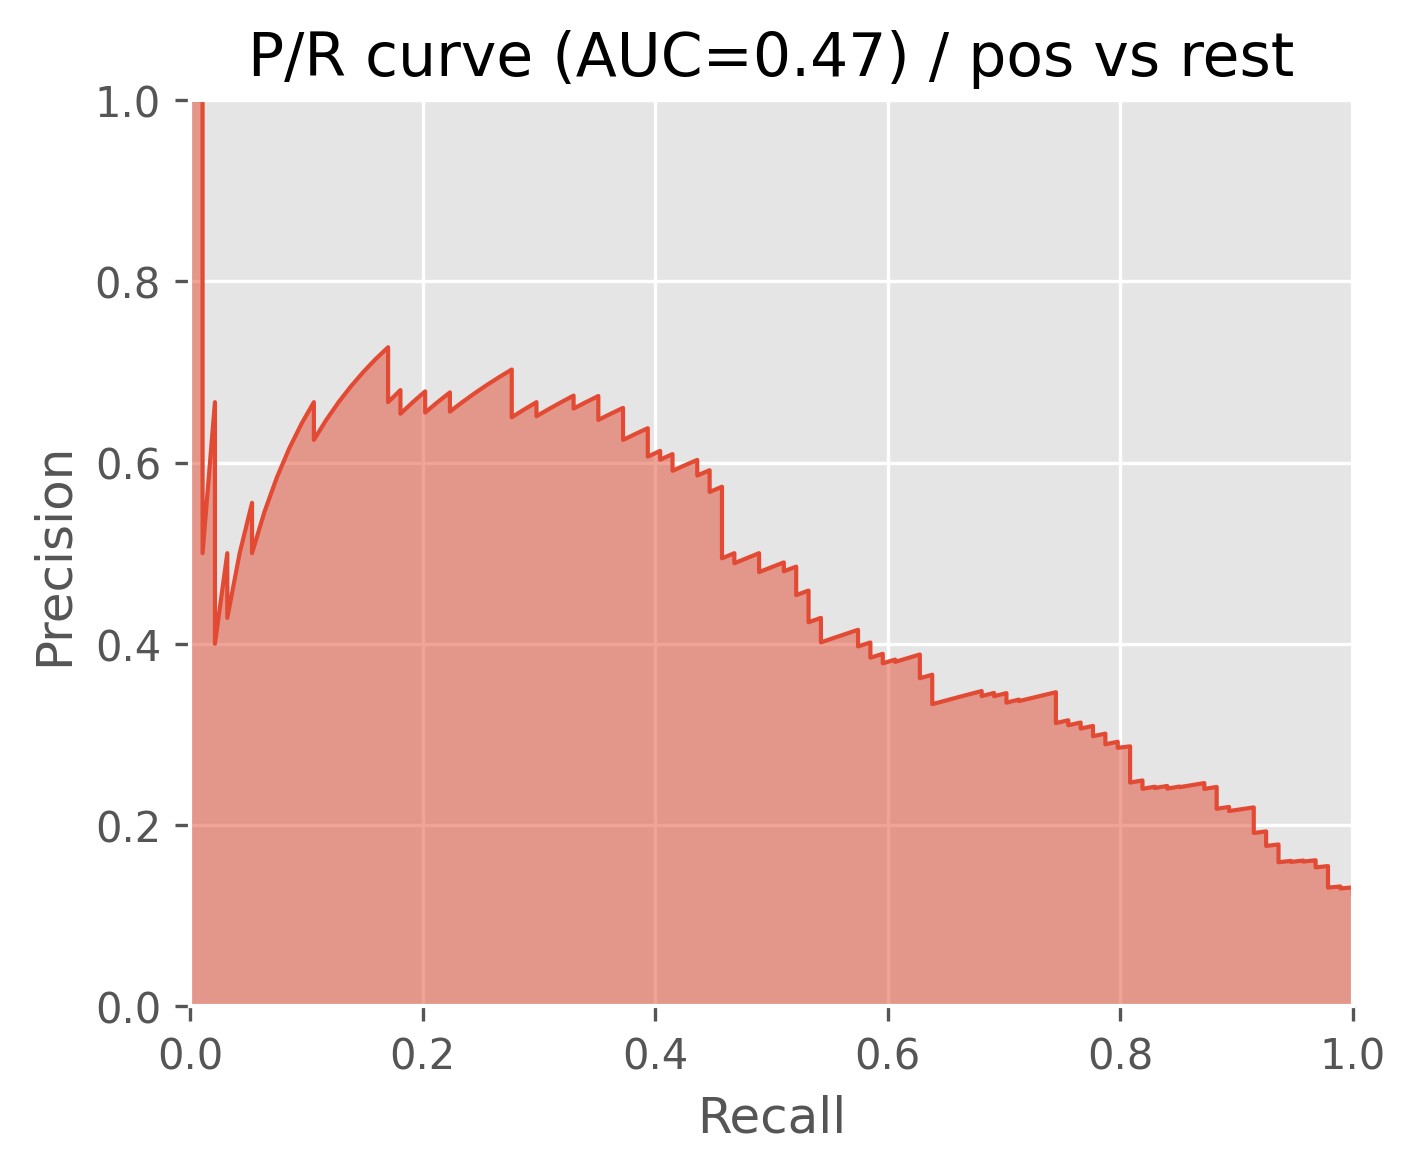

In [26]:
plot_pr(pr_scores[median], precisions[median], recalls[median], label="pos vs rest")

In [27]:
print("== Neg vs. rest (BEST) ==")
X = X_orig
Y = tweak_labels(Y_orig, ["negative"])
pr_scores, precisions, recalls, median = train_model(lambda: create_ngram_model(best_params), X, Y)

== Neg vs. rest (BEST) ==
Mean acc=0.884	Mean P/R AUC=0.641
Mean acc=0.876	Mean P/R AUC=0.649
Mean acc=0.881	Mean P/R AUC=0.650
Mean acc=0.879	Mean P/R AUC=0.649
Mean acc=0.879	Mean P/R AUC=0.645
Mean acc=0.879	Mean P/R AUC=0.649
Mean acc=0.880	Mean P/R AUC=0.655
Mean acc=0.880	Mean P/R AUC=0.651
Mean acc=0.880	Mean P/R AUC=0.656
Mean acc=0.880	Mean P/R AUC=0.656


<Figure size 432x288 with 0 Axes>

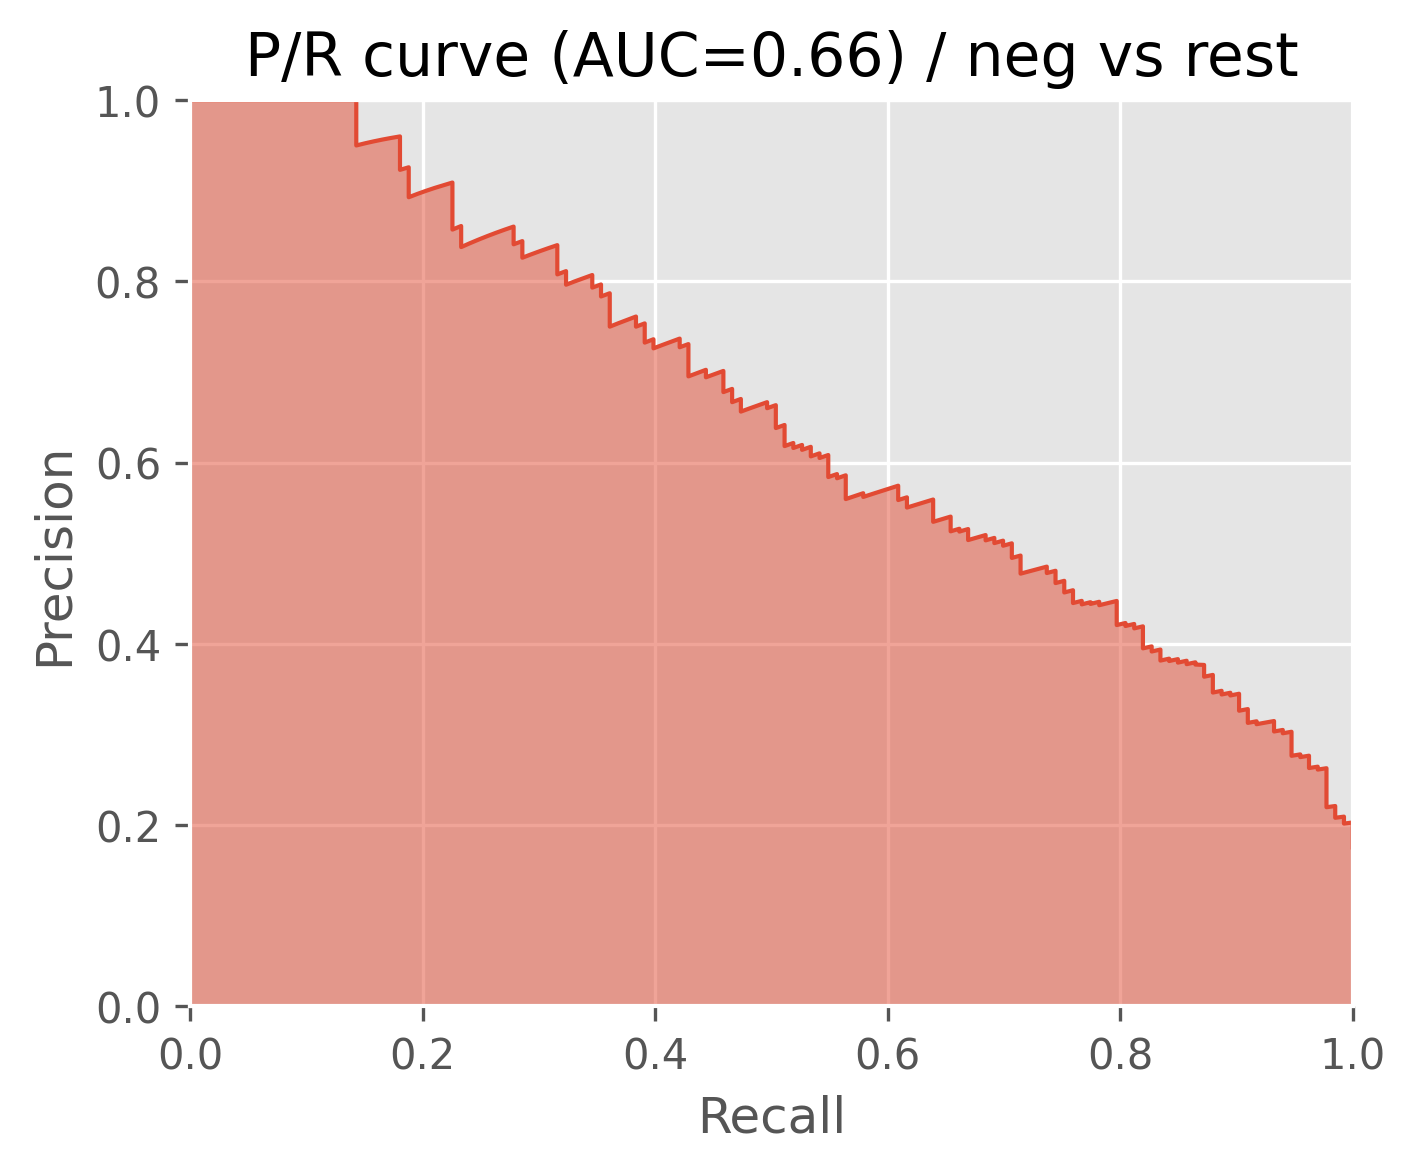

In [28]:
plot_pr(pr_scores[median], precisions[median], recalls[median], label="neg vs rest")

The devastating results for positive tweets against the rest and negative tweets against the rest improve if the vectorizer and classifier are configured with those parameters that have been just found out. Also, the positive versus negative classification shows slightly inferior performance:
|              | First try | First try | GridCV    | GridCV  |
| ------------ | --------- | --------- | --------- | ------- |
|              | Acc       | P/R AUC   | Acc       | P/R AUC |
| Pos vs neg   | 0.783     | 0.883     | 0.807     | 0.876   |
| Sent vs rest | 0.723     | 0.696     | 0.783     | 0.694   |
| Pos vs rest  | 0.864     | 0.354     | 0.880     | 0.492   |
| Neg vs rest  | 0.837     | 0.548     | 0.880     | 0.656   |

Indeed, the P/R curves look much better (note that the plots are from the medium of the fold classifiers, thus, the slightly-diverging AUC values). Nevertheless, those classifiers probably still wouldn't be used. Time for something completely different...

## Cleaning tweets

New constraints lead to new forms. So far, all the diverse emoticons and abbreviations have been ignored. See how much it can be improved by taking that into account. For this endeavor, the custom preprocessor() will has to be provided to TfidfVectorizer.

First, a range of frequent emoticons and their replacements are defined in a dictionary. Although more distinct replacements can be found, go with obvious positive or negative words to help the classifier:

In [29]:
emo_repl = {
    # positive emoticons
    "&lt;3": " good ",
    ":d": " good ", # :D in lower case
    ":dd": " good ", # :DD in lower case
    "8)": " good ",
    ":-)": " good ",
    ":)": " good ",
    ";)": " good ",
    "(-:": " good ",
    "(:": " good ",
    # negative emoticons:
    ":/": " bad ",
    ":&gt;": " sad ",
    ":')": " sad ",
    ":-(": " bad ",
    ":(": " bad ",
    ":S": " bad ",
    ":-S": " bad ",
}
# make sure that e.g. :dd is replaced before :d
emo_repl_order = [k for (k_len, k) in reversed(sorted([(len(k), k) for k in emo_repl.keys()]))]

Then, abbreviations are defined as regular expressions together with their expansions (b marks the word boundary):

In [30]:
import re

re_repl = {
    r"\br\b": "are",
    r"\bu\b": "you",
    r"\bhaha\b": "ha",
    r"\bhahaha\b": "ha",
    r"\bdon't\b": "do not",
    r"\bdoesn't\b": "does not",
    r"\bdidn't\b": "did not",
    r"\bhasn't\b": "has not",
    r"\bhaven't\b": "have not",
    r"\bhadn't\b": "had not",
    r"\bwon't\b": "will not",
    r"\bwouldn't\b": "would not",
    r"\bcan't\b": "can not",
    r"\bcannot\b": "can not",
}

def preprocessor(tweet):
    tweet = tweet.lower()
    for k in emo_repl_order:
        tweet = tweet.replace(k, emo_repl[k])
    for r, repl in re_repl.items():
        tweet = re.sub(r, repl, tweet)
    return tweet
    
def create_ngram_model_emoji(params=None, preprocessor=None):    
    tfidf_ngrams = TfidfVectorizer(preprocessor=preprocessor, analyzer="word")
    clf = MultinomialNB()
    pipeline = Pipeline([('tfidf', tfidf_ngrams), ('clf', clf)])
    if params:
        pipeline.set_params(**params)
    return pipeline

Remember that a dictionary of the parameters that was found to be best using GridSearchCV was created. It will be passed to create_ngram_model_emoji so that the new model improves on what it already has been figured out. As train_model requires a classifier factory, because it will be instantiated over and over again, the factory is created using Python's lambda:

In [31]:
print("== Pos/neg vs. irrelevant/neutral ==")
X = X_orig
Y = tweak_labels(Y_orig, ["positive", "negative"])
pr_scores, precisions, recalls, median = train_model(lambda: create_ngram_model_emoji(best_params, preprocessor), X, Y)

== Pos/neg vs. irrelevant/neutral ==
Mean acc=0.777	Mean P/R AUC=0.660
Mean acc=0.775	Mean P/R AUC=0.685
Mean acc=0.771	Mean P/R AUC=0.673
Mean acc=0.771	Mean P/R AUC=0.680
Mean acc=0.773	Mean P/R AUC=0.686
Mean acc=0.778	Mean P/R AUC=0.689
Mean acc=0.778	Mean P/R AUC=0.693
Mean acc=0.776	Mean P/R AUC=0.687
Mean acc=0.778	Mean P/R AUC=0.691
Mean acc=0.781	Mean P/R AUC=0.695


In [32]:
print("== Pos vs. neg ==")
pos_neg = np.logical_or(Y_orig == "positive", Y_orig == "negative")
X = X_orig[pos_neg]
Y = Y_orig[pos_neg]
Y = tweak_labels(Y, ["positive"])

pr_scores, precisions, recalls, median = train_model(lambda: create_ngram_model_emoji(best_params, preprocessor), X, Y)

== Pos vs. neg ==
Mean acc=0.836	Mean P/R AUC=0.909
Mean acc=0.816	Mean P/R AUC=0.888
Mean acc=0.794	Mean P/R AUC=0.877
Mean acc=0.804	Mean P/R AUC=0.881
Mean acc=0.804	Mean P/R AUC=0.884
Mean acc=0.811	Mean P/R AUC=0.884
Mean acc=0.810	Mean P/R AUC=0.876
Mean acc=0.817	Mean P/R AUC=0.881
Mean acc=0.820	Mean P/R AUC=0.883
Mean acc=0.815	Mean P/R AUC=0.881


In [33]:
print("== Pos vs. rest ==")
X = X_orig
Y = tweak_labels(Y_orig, ["positive"])

pr_scores, precisions, recalls, median = train_model(lambda: create_ngram_model_emoji(best_params, preprocessor), X, Y)

== Pos vs. rest ==
Mean acc=0.892	Mean P/R AUC=0.464
Mean acc=0.885	Mean P/R AUC=0.458
Mean acc=0.884	Mean P/R AUC=0.486
Mean acc=0.885	Mean P/R AUC=0.500
Mean acc=0.885	Mean P/R AUC=0.522
Mean acc=0.886	Mean P/R AUC=0.512
Mean acc=0.885	Mean P/R AUC=0.506
Mean acc=0.884	Mean P/R AUC=0.499
Mean acc=0.883	Mean P/R AUC=0.494
Mean acc=0.883	Mean P/R AUC=0.500


In [34]:
print("== Neg vs. rest ==")
X = X_orig
Y = tweak_labels(Y_orig, ["negative"])

pr_scores, precisions, recalls, median = train_model(lambda: create_ngram_model_emoji(best_params, preprocessor), X, Y)

== Neg vs. rest ==
Mean acc=0.872	Mean P/R AUC=0.631
Mean acc=0.870	Mean P/R AUC=0.641
Mean acc=0.878	Mean P/R AUC=0.645
Mean acc=0.876	Mean P/R AUC=0.645
Mean acc=0.876	Mean P/R AUC=0.644
Mean acc=0.877	Mean P/R AUC=0.648
Mean acc=0.880	Mean P/R AUC=0.655
Mean acc=0.879	Mean P/R AUC=0.650
Mean acc=0.880	Mean P/R AUC=0.656
Mean acc=0.881	Mean P/R AUC=0.657


Certainly, there are many more abbreviations that can be used here. But already with this limited set, an improvement of roughly half a point is obtained for positive versus negative. Copying over the preceding table and filling in the numbers for the new approach, it is seen that it approves a bit for every classifier:
|              | First try | First try | GridCV    | GridCV  | GridCV+Cleaning | GridCV+Cleaning |
| ------------ | --------- | --------- | --------- | ------- | --------------- | --------------- |
|              | Acc       | P/R AUC   | Acc       | P/R AUC | Acc             | P/R AUC         |
| Pos vs neg   | 0.783     | 0.883     | 0.807     | 0.876   | 0.815           | 0.881           |
| Sent vs rest | 0.723     | 0.696     | 0.783     | 0.694   | 0.781           | 0.695           |
| Pos vs rest  | 0.864     | 0.354     | 0.880     | 0.492   | 0.883           | 0.500           |
| Neg vs rest  | 0.837     | 0.548     | 0.880     | 0.656   | 0.881           | 0.657           |

## Taking the word types into account

So far, the hope was that simply using the words independent of each other with the bag-of-words approach would suffice. Just from the intuition, however, it is known that neutral tweets probably contain a higher fraction of nouns, while positive or negative tweets are more colorful, requiring more adjectives and verbs. What if this linguistic information of the tweets is used as well? If how many words in a tweet were nouns, verbs, adjectives, and so on could be found out, the classifier could probably take that into account too.

### Determining the word types

This is what part-of-speech tagging, or POS tagging, is all about. A POS tagger analyzes a sentence and tags each word with its part of speech, for example, whether the word book is a noun (this is a good book) or a verb (could you please book the flight?).

You might have already guessed that NLTK will play its role in this area as well. The POS tagger that will be used, nltk.pos_tag(), is actually a full-blown classifier trained using manuallyannotated sentences from the Penn Treebank Project. It takes as input a list of word tokens and outputs a list of tuples, where each element contains the part of the original sentence and its part-of-speech tag:

In [35]:
import nltk

print(nltk.pos_tag(nltk.word_tokenize("This is a good book.")))
print(nltk.pos_tag(nltk.word_tokenize("Could you please book the flight?")))

[('This', 'DT'), ('is', 'VBZ'), ('a', 'DT'), ('good', 'JJ'), ('book', 'NN'), ('.', '.')]
[('Could', 'NNP'), ('you', 'PRP'), ('please', 'VBP'), ('book', 'NN'), ('the', 'DT'), ('flight', 'NN'), ('?', '.')]


The POS tag abbreviations are taken from the Penn Treebank (adapted from https://www.anc.org/OANC/penn.html).
| POS tag | Description                           | Example                                 |
| ------- | ------------------------------------- | --------------------------------------- |
| CC      | coordinating conjunction              | and                                     |
| CD      | cardinal number 	                  | 1, third                                |
| DT      | determiner 	                          | the                                     |
| EX      | existential there 	                  | there is                                |
| FW      | foreign word 	                      | d'hoevre                                |
| IN      | preposition/subordinating conjunction | in, of, like                            |
| JJ      | adjective 	                          | green                                   |     
| JJR     | adjective, comparative 	              | greener                                 |
| JJS     | adjective, superlative 	              | greenest                                |
| LS      | list marker 	                      | 1)                                      |
| MD      | modal 	                              | could, will                             |
| NN      | noun, singular or mass 	              | table                                   |
| NNS     | noun plural 	                      | tables                                  |
| NNP     | proper noun, singular 	              | John                                    |
| NNPS    | proper noun, plural 	              | Vikings                                 |
| PDT     | predeterminer 	                      | both the boys                           |
| POS     | possessive ending 	                  | friend's                                |
| PRP     | personal pronoun 	                  | I, he, it                               |
| PRP$    | possessive pronoun 	                  | my, his                                 |
| RB      | adverb 	                              | however, usually, naturally, here, good |
| RBR     | adverb, comparative 	              | better                                  |
| RBS     | adverb, superlative 	              | best                                    |
| RP      | particle 	                          | give up                                 |
| TO      | to 	                                  | to go, to him                           |
| UH      | interjection 	                      | uhhuhhuhh                               |
| VB      | verb, base form 	                  | take                                    |
| VBD     | verb, past tense 	                  | took                                    |
| VBG     | verb, gerund/present participle 	  | taking                                  |
| VBN     | verb, past participle 	              | taken                                   |
| VBP     | verb, sing. present, non-3d 	      | take                                    |
| VBZ     | verb, 3rd person sing. present 	      | takes                                   |
| WDT     | wh-determiner 	                      | which                                   |
| WP      | wh-pronoun 	                          | who, what                               |
| WP$     | possessive wh-pronoun 	              | whose                                   |
| WRB     | wh-abverb 	                          | where, when                             | 

With these tags, it is pretty easy to filter the desired tags from the output of pos_tag(). All words whose tags start with NN for nouns, VB for verbs, JJ for adjectives, and RB for adverbs simply have to be counted.

### Successfully cheating using SentiWordNet

While linguistic information, as mentioned in the preceding section, will most likely help, there is something better that can be used to harvest it: SentiWordNet. Some examples are as follows:
| POS | ID       | PosScore | NegScore | SynsetTerms           | Description                                                                                  |
| --- | -------- | -------- | -------- | --------------------- | -------------------------------------------------------------------------------------------- |
| a   | 00311354 | 0.25     | 0.125    | studious#1            | Marked by care and effort; made a studious attempt to fix the television set                 |
| a   | 00311663 | 0        | 0.5      | careless#1            | Marked by lack of attention or consideration  or forethought or thoroughness; not careful... |
| n   | 03563710 | 0        | 0        | implant#1             | A prosthesis placed permanently in tissue                                                    |
| n   | 00362128 | 0        | 0        | kink#2 curve#5 curl#1 | Form a curl, curve, or kink; the cigar smoke curled up at the ceiling                        |

With the information in the POS column, it enables to distinguish between the noun bookand the verb book. PosScore and NegScore together will help to determine the neutrality of the word, which is 1-PosScore-NegScore. SynsetTerms lists all words in the set that are synonyms. The ID and Description columns can be safely ignored.

The synset terms have a number appended, because some occur multiple times in different synsets. For example, fantasize conveys two different meanings, which also leads to different
scores:
| POS | ID       | PosScore | NegScore | SynsetTerms                       | Description                                                                            |
| --- | -------- | -------- | -------- | --------------------------------- | -------------------------------------------------------------------------------------- |
| v   | 01636859 | 0.375    | 0        | fantasize#2 fantasise#2           | Portray in the mind; he is fantasizing the ideal wife                                  |
| v   | 01637368 | 0        | 0.125    | fantasy#1 fantasize#1 fantasise#1 | Indulge in fantasies; he is fantasizing when he says he plans to start his own company |

To find out which of the synsets to take, the meaning of the tweets will be needed to really understand, which is beyond the scope of this chapter. For this task, take the easy route and simply average the scores over all the synsets in which a term is found. For fantasize, PosScore will be 0.1875 and NegScore will be 0.0625.

The following function, load_sent_word_net(), does all that and returns a dictionary where the keys are strings of the word type/word form, for example, n/implant, and the values are the positive and negative scores:

In [36]:
import collections
import requests

def load_sent_word_net():
    # making our life easier by using a dictionary that
    # automatically creates an empty list whenever we access
    # a not yet existing key
    sent_scores = collections.defaultdict(list)
    
    with open(os.path.join(DATA_DIR, "SentiWordNet_3.0.0.txt"), "r") as csvfile:
        reader = csv.reader(csvfile, delimiter='\t', quotechar='"')
        for line in reader:
            if line[0].startswith("#"):
                continue
            if len(line)==1:
                continue

            POS, ID, PosScore, NegScore, SynsetTerms, Gloss = line
            if len(POS)==0 or len(ID)==0:
                continue
            for term in SynsetTerms.split(" "):
                # drop number at the end of every term
                term = term.split("#")[0] 
                term = term.replace("-", " ").replace("_", " ")
                key = "%s/%s"%(POS, term.split("#")[0])
                sent_scores[key].append((float(PosScore), float(NegScore)))

    for key, value in sent_scores.items():
         sent_scores[key] = np.mean(value, axis=0)

    return sent_scores

url = 'https://raw.githubusercontent.com/aesuli/SentiWordNet/master/data/SentiWordNet_3.0.0.txt'
r = requests.get(url, allow_redirects=True)

open(os.path.join(DATA_DIR, "SentiWordNet_3.0.0.txt"), 'wb').write(r.content)

13590743

### The first estimator

Now, there is everything in place to create the first vectorizer. The most convenient way to do it is to inherit it from BaseEstimator. It requires to implement the following three methods:
* get_feature_names(): This returns a list of strings of the features that will be returned in transform().
* fit(document, y=None): As a classifier is not being implemented, ignore this one and simply return self.
* transform(documents): This returns numpy.array(), containing an array of a shape(len(documents), len(get_feature_names)). This means, for every document in documents, it has
to return a value for every feature name in get_feature_names().

Here is the implementation:

In [37]:
from sklearn.base import BaseEstimator

sent_word_net = load_sent_word_net()

class LinguisticVectorizer(BaseEstimator):
    def get_feature_names(self):
        return np.array([
            'sent_neut', 'sent_pos', 'sent_neg',
            'nouns', 'adjectives', 'verbs', 'adverbs',
            'allcaps', 'exclamation', 'question', 'hashtag',
            'mentioning'
        ])

    # don't fit here but need to return the reference
    # so that it can be used like fit(d).transform(d)
    def fit(self, documents, y=None):
        return self

    def _get_sentiments(self, d):
        sent = tuple(d.split())
        tagged = nltk.pos_tag(sent)
        pos_vals = []
        neg_vals = []
        nouns = 0.
        adjectives = 0.
        verbs = 0.
        adverbs = 0.
        for w, t in tagged:
            p, n = 0, 0
            sent_pos_type = None
            if t.startswith("NN"):
                sent_pos_type = "n"
                nouns += 1
            elif t.startswith("JJ"):
                sent_pos_type = "a"
                adjectives += 1
            elif t.startswith("VB"):
                sent_pos_type = "v"
                verbs += 1
            elif t.startswith("RB"):
                sent_pos_type = "r"
                adverbs += 1
            if sent_pos_type is not None:
                sent_word = "%s/%s" % (sent_pos_type, w)
                if sent_word in sent_word_net:
                    p, n = sent_word_net[sent_word]
            pos_vals.append(p)
            neg_vals.append(n)
        l = len(sent)
        avg_pos_val = np.mean(pos_vals)
        avg_neg_val = np.mean(neg_vals)
        return [1-avg_pos_val-avg_neg_val, avg_pos_val, avg_neg_val, nouns/l, adjectives/l, verbs/l, adverbs/l]
    
    def transform(self, documents):
        obj_val, pos_val, neg_val, nouns, adjectives, verbs, adverbs = np.array([self._get_sentiments(d) for d in documents]).T
        allcaps = []
        exclamation = []
        question = []
        hashtag = []
        mentioning = []
        for d in documents:
            allcaps.append(np.sum([t.isupper() for t in d.split() if len(t)>2]))
            exclamation.append(d.count("!"))
            question.append(d.count("?"))
            hashtag.append(d.count("#"))
            mentioning.append(d.count("@"))
        result = np.array([obj_val, pos_val, neg_val, nouns, adjectives, verbs, adverbs, allcaps, exclamation, question, hashtag, mentioning]).T
        return result

### Putting everything together

Nevertheless, using these linguistic features in isolation without the words themselves will not take very far. Therefore, the TfidfVectorizer parameter has to been combined with the linguistic features. This can be done with scikit-learn's FeatureUnion class. It is initialized in the same manner as Pipeline; however, instead of evaluating the estimators in a sequence, each passing the output of the previous one to the next one, FeatureUnion does it in parallel and joins the output vectors afterward:

In [38]:
from sklearn.pipeline import FeatureUnion

def preprocessor(tweet):
    tweet = tweet.lower()
    for k in emo_repl_order:
        tweet = tweet.replace(k, emo_repl[k])
    for r, repl in re_repl.items():
        tweet = re.sub(r, repl, tweet)
    return tweet.replace("-", " ").replace("_", " ")

def create_union_model(params=None, preprocessor=None):
    tfidf_ngrams = TfidfVectorizer(preprocessor=preprocessor, analyzer="word")
    ling_stats = LinguisticVectorizer()
    all_features = FeatureUnion([('ling', ling_stats), ('tfidf', tfidf_ngrams)])
    clf = MultinomialNB()
    pipeline = Pipeline([('all', all_features), ('clf', clf)])
    if params:
        pipeline.set_params(**params)
    return pipeline

print("== Pos vs. neg ==")
pos_neg = np.logical_or(Y_orig == "positive", Y_orig == "negative")
X = X_orig[pos_neg]
Y = Y_orig[pos_neg]
Y = tweak_labels(Y, ["positive"])

best_params = dict(
    all__tfidf__ngram_range=(1, 3),
    all__tfidf__min_df=2,
    all__tfidf__stop_words=None,
    all__tfidf__smooth_idf=False,
    all__tfidf__use_idf=False,
    all__tfidf__sublinear_tf=True,
    all__tfidf__binary=False,
    clf__alpha=0.05,
)

pr_scores, precisions, recalls, median = train_model(lambda: create_union_model(best_params, preprocessor), X, Y)

== Pos vs. neg ==
Mean acc=0.801	Mean P/R AUC=0.888
Mean acc=0.796	Mean P/R AUC=0.875
Mean acc=0.773	Mean P/R AUC=0.862
Mean acc=0.781	Mean P/R AUC=0.868
Mean acc=0.779	Mean P/R AUC=0.866
Mean acc=0.785	Mean P/R AUC=0.869
Mean acc=0.785	Mean P/R AUC=0.862
Mean acc=0.793	Mean P/R AUC=0.869
Mean acc=0.796	Mean P/R AUC=0.872
Mean acc=0.795	Mean P/R AUC=0.867


In [39]:
print("== Pos/neg vs. irrelevant/neutral ==")
X = X_orig
Y = tweak_labels(Y_orig, ["positive", "negative"])
pr_scores, precisions, recalls, median = train_model(lambda: create_union_model(best_params, preprocessor), X, Y)

== Pos/neg vs. irrelevant/neutral ==
Mean acc=0.751	Mean P/R AUC=0.652
Mean acc=0.755	Mean P/R AUC=0.671
Mean acc=0.752	Mean P/R AUC=0.655
Mean acc=0.753	Mean P/R AUC=0.664
Mean acc=0.754	Mean P/R AUC=0.666
Mean acc=0.761	Mean P/R AUC=0.675
Mean acc=0.762	Mean P/R AUC=0.683
Mean acc=0.760	Mean P/R AUC=0.677
Mean acc=0.763	Mean P/R AUC=0.679
Mean acc=0.764	Mean P/R AUC=0.681


In [40]:
print("== Pos vs. rest ==")
X = X_orig
Y = tweak_labels(Y_orig, ["positive"])

pr_scores, precisions, recalls, median = train_model(lambda: create_union_model(best_params, preprocessor), X, Y)

== Pos vs. rest ==
Mean acc=0.891	Mean P/R AUC=0.477
Mean acc=0.881	Mean P/R AUC=0.463
Mean acc=0.884	Mean P/R AUC=0.496
Mean acc=0.886	Mean P/R AUC=0.512
Mean acc=0.885	Mean P/R AUC=0.527
Mean acc=0.886	Mean P/R AUC=0.510
Mean acc=0.885	Mean P/R AUC=0.505
Mean acc=0.883	Mean P/R AUC=0.497
Mean acc=0.883	Mean P/R AUC=0.493
Mean acc=0.883	Mean P/R AUC=0.499


In [41]:
print("== Neg vs. rest ==")
X = X_orig
Y = tweak_labels(Y_orig, ["negative"])

pr_scores, precisions, recalls, median = train_model(lambda: create_union_model(best_params, preprocessor), X, Y)

== Neg vs. rest ==
Mean acc=0.835	Mean P/R AUC=0.563
Mean acc=0.840	Mean P/R AUC=0.570
Mean acc=0.846	Mean P/R AUC=0.576
Mean acc=0.847	Mean P/R AUC=0.586
Mean acc=0.846	Mean P/R AUC=0.579
Mean acc=0.849	Mean P/R AUC=0.589
Mean acc=0.854	Mean P/R AUC=0.601
Mean acc=0.856	Mean P/R AUC=0.597
Mean acc=0.857	Mean P/R AUC=0.603
Mean acc=0.858	Mean P/R AUC=0.603


Training and testing on the combined featurizers, however, is a bit disappointing:
|              | First try | First try | GridCV    | GridCV  | GridCV+Cleaning | GridCV+Cleaning | GridCV+Cleaning+SentiWord | GridCV+Cleaning+SentiWord |
| ------------ | --------- | --------- | --------- | ------- | --------------- | --------------- | ------------------------- | ------------------------- |
|              | Acc       | P/R AUC   | Acc       | P/R AUC | Acc             | P/R AUC         | Acc                       | P/R AUC                   |
| Pos vs neg   | 0.783     | 0.883     | 0.807     | 0.876   | 0.815           | 0.881           | 0.795                     | 0.867                     |
| Sent vs rest | 0.723     | 0.696     | 0.783     | 0.694   | 0.781           | 0.695           | 0.764                     | 0.681                     |
| Pos vs rest  | 0.864     | 0.354     | 0.880     | 0.492   | 0.883           | 0.500           | 0.883                     | 0.499                     |
| Neg vs rest  | 0.837     | 0.548     | 0.880     | 0.656   | 0.881           | 0.657           | 0.858                     | 0.603                     |

With these results, no one probably wants to pay the price of the much costlier SentiWord approach, if a significant post in P/R AUC is not obtained. Instead, probably choose the GridCV + Cleaning approach, and first use the classifier that determines whether the tweet contains a sentiment at all (pos/neg versus irrelevant/neutral), and then in case it does, use the positive-versus-negative classifier to determine the actual sentiment.